### This notebook analyzes the Thermal Wind Transport (TWT) and Bottom Velocity Transport (BVT) through the Drake Passage at ~69W in GFDL models using the Drake Passage cross-section /pp model output. This notebook quantifies the difference between computing these quatities assuming a constant thickness vs. using time-varying thkcello.

### The TWT is defined here as the volume transport from geostrophic velocity, i.e., the component of the flow due to horizonal gradients in density in a rotating system. A level of no motion is assumed at the ocean bottom (ugeo = 0). The transport due to bottom reference assumption of zero is also computed. The sum of these two transports gives the total geostrophic component of the flow.

- Potential Temperature and Salinity monthly output are used to compute potential density referenced to the local pressure level.
- xgcm differencing is used to then compute drho / dy across the passage which is then used to compute geostrophic shear and geostrophic velocity following Thermal Wind Balance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
from xgcm import Grid
import momlevel as ml

### Use Dask SLURMCluster

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 

portdash=19131

cluster = SLURMCluster(
    queue="analysis",
    cores=4,
    project="gfdl_o",
    job_extra=["-C bigmem"],
    memory="128GB",
    walltime="04:00:00",
    scheduler_options={"dashboard_address":f'{portdash}'},
)

client=Client(cluster)
client

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.208.147.167:19131/status,
Dashboard: http://140.208.147.167:19131/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.208.147.167:39615,Workers: 0
Dashboard: http://140.208.147.167:19131/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.scale(10)

## Load model output for GFDL high-res configurations
#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#####
##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [5]:
## There are some issues with the cm4 cmip6 output, so preprocessing is required when reading 
## in the data using xr.open_mfdataset()

def preprocess_cmip6_uo(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(10,144))
    return dsnew

def preprocess_cmip6_vol(ds):
    '''slice in the yh_sub01 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub01=slice(10,144))
    return dsnew

def load_ocean_Drake_Passage(model_config):
    if model_config == 'Odiv-183':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                               combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                               combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                               combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                               combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-184':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-170':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-191':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-200':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-206':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'Odiv-207':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    
    if model_config == 'cmip6-cm4':
        ds_T = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*thetao.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_S = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*so.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_u = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*uo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_umo = xr.open_mfdataset('/net/Rebecca.Beadling/dora_scripts/data/cm4_cmip6/*.umo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    
    return ds_drake

def annual_mean(array):
    """
    weight by days in each month
    """
    # Determine month length
    month_length = array.time.dt.days_in_month
    # Calculate weights
    wgts = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Setup our masking for nan values
    cond = array.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    array_sum = (array * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return array_sum / ones_out

### Load static fields and add z_l and z_i dimensions which will be needed for xgcm grid object

In [6]:
static_om4p125 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')
static_om4p25 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')

### Load volcello fields

In [31]:
thk_odiv_207 = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/ocean_month_z.019601-020012.thkcello.nc',
                                combine='by_coords', use_cftime=True).chunk({'xh':120,'yh':120,'time':60})

In [17]:
## Load om4p125 configurations:
odiv_183_184 = xr.concat([load_ocean_Drake_Passage('Odiv-183'),
                          load_ocean_Drake_Passage('Odiv-184')],
                          dim='time').rename({'yh_sub01':'yh',
                                              'xh_sub01':'xh',
                                              'xq_sub01':'xq',
                                              }).isel(yh=slice(6,None))

#odiv_191 = load_ocean_Drake_Passage('Odiv-191').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_200 = load_ocean_Drake_Passage('Odiv-200').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_206 = load_ocean_Drake_Passage('Odiv-206').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

odiv_207 = load_ocean_Drake_Passage('Odiv-207').rename({'yh_sub01':'yh',
                                              'xh_sub01':'xh',
                                              'xq_sub01':'xq',
                                              }).isel(yh=slice(6,None))

In [30]:
## Load om4p25 configurations:
#odiv_170 = load_ocean_Drake_Passage('Odiv-170').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#cmip6_cm4 = load_ocean_Drake_Passage('cmip6-cm4').rename({'xh_sub01':'xh',
#                                                          'xq_sub01':'xq',         
#                                              })

### Compute the locally referenced potential density -- this is equivalent to in-situ density at a specific point.
##### Rho is computed using the momlevel.derived.calc_rho funtion documented here:https://momlevel.readthedocs.io/en/latest/eos.html#calculating-in-situ-density. This computes density using the Wright 1997, J. Atmos. Ocean. Tech., 14, 735 - 740 equation of state (EOS). Pressure is approximated as depth * 1e4 (to get pressure in Pa).


In [18]:
rho_odiv_183_184 = ml.derived.calc_rho(odiv_183_184.thetao,
                                       odiv_183_184.so,
                                       odiv_183_184.z_l*1e4)
#rho_odiv_170 = ml.derived.calc_rho(odiv_170.thetao,
#                                       odiv_170.so,
#                                       odiv_170.z_l*1e4)
#rho_odiv_191 = ml.derived.calc_rho(odiv_191.thetao,
#                                       odiv_191.so,
#                                       odiv_191.z_l*1e4)
#rho_odiv_200 = ml.derived.calc_rho(odiv_200.thetao,
#                                       odiv_200.so,
#                                       odiv_200.z_l*1e4)
#rho_odiv_206 = ml.derived.calc_rho(odiv_206.thetao,
#                                       odiv_206.so,
#                                       odiv_206.z_l*1e4)
rho_odiv_207 = ml.derived.calc_rho(odiv_207.thetao,
                                       odiv_207.so,
                                       odiv_207.z_l*1e4)

### Define Constants and Functions

In [19]:
g = 9.81       ## m s-2 
rho_0 = 1035.  ## kg m-3 Ref density used in MOM6

def compute_coriolis(darray):
    """
    Calculate the Coriolis frequency (f) if not provided in the ocean_static file
    
    Parameters
    -----------
    darray: xarray.DataArray
        Two dimensional data array containing model's geolat variable
    
    Returns
    -----------
    f: xarray.DataArray
        Two dimensional data array containing computed Corilis parameter f. 
    """
    
    w = 7.292124e-5                             #Earth's angular velocity in rad s-1 (2*pi / T, where T is Earth's sidereal period, 23 hrs, 56 min, 4 sec.)
    lat_rad = (darray.geolat_c)*((2*np.pi)/360) #np.sin takes an angle in radians, so need to convert lat from degrees to rad.
    f = (2*w)*np.sin(lat_rad)
    return f


def compute_dz_between_u_points(thk):
    
    """
    Calculate the discrete vertical distance (dz) between two points where 
    the zonal geostrophic velocities are located that are derived from our
    potential density field. These vertically are on the cell centers (z_l)
    , but we must account for partial cells are the ocean bottom.
       
    For du/dz, the vertical shear, the dz refers to the depth in m between
    our two u velocities, this is NOT equivalent to grid cell thickness. 
    The correct dz between u points is computed using this function.
    
    Parameters
    ----------
    thk : xarray.DataArray
        Data Array containing interpolated thickness on xh,yq points
        which as already been subset in yq for the Drake Passage
        
    Returns
    ----------
    dz_u_points: xarray.DataArray
        Data Array containing the distance in m between zonal 
        geostrophic velocities to be used in Thermal Wind Transport calculation
    """
    
    kmax = thk.shape[0]                             ## of z levels
    zl  = 0.0 * thk[:]                              ## Thickness is zero everywhere 
    zl[0] = 0.5 * thk[0]                            ## Multiple first element by 0.5 .... first element is the top cell

    k = 1
    while k < kmax:
        zl[k] = (0.5*(thk[k-1])) + (0.5*(thk[k]))
        k=k+1

    dz_u_points = xr.DataArray(zl,dims=thk.dims,coords=thk.coords)
    
    return dz_u_points


def slice_static_array(sliced_array,static_array):
    """ 
    Slice the ocean static array along the Y dimension so that it can be used to 
    create xgcm grid object to be used with the Drake Passage post-processed model
    output which is provided only at the Drake Passage cross-section.
    
    Parameters
    ----------
    sliced_array : xarray.DataArray
        Data Array containing drake passage subset data.
        
    static_array : xarray.DataArray
        Data Array containing full ocean static field that
        you wish to slice.
        
    Returns
    ----------
    static_sliced_array: xarray.DataArray
        Data Array containing the static field sliced in the Y dimensions to be used
        with the post processed Drake Passage subset data.
    
    """
    
    ## Find yq point adjacent to the first yh point in our rho array:
    y_south_0 = sliced_array.yh[0]
    y_south_1 = sliced_array.yh[1]
    diff_y_south = np.abs(y_south_1 - y_south_0)
    yq_point_south = y_south_0 + (diff_y_south/2)

    ## Find yq point adjacent to the last yh point in our rho array:
    y_north_1 = sliced_array.yh[-1]
    y_north_0 = sliced_array.yh[-2]
    diff_y_north = np.abs(y_north_1 - y_north_0)
    yq_point_north = y_north_1 + (diff_y_north/2)

    ## Find index where yq points are:
    yq_south_idx = np.abs(static_array.yq - yq_point_south.values).argmin()
    yq_north_idx = np.abs(static_array.yq - yq_point_north.values).argmin()
    yh_south_idx = np.abs(static_array.yh - y_south_0.values).argmin()
    yh_north_idx = np.abs(static_array.yh - y_north_1.values).argmin()

    ## We must slice our static array to be equal to the section
    ## defined from yq=288 to yq=578, (so indexed as 578+1)
    static_sliced_array = static_array.isel(yq=slice(yq_south_idx.values,yq_north_idx.values + 2),
                                            yh=slice(yh_south_idx.values,yh_north_idx.values+1))
    
    
    return static_sliced_array


def slice_array(sliced_array,array_to_slice):
    """ 
    Slice the tracer array along the Y dimension so that it can be used to 
    create xgcm grid object to be used with the Drake Passage post-processed model
    output which is provided only at the Drake Passage cross-section.
    
    Parameters
    ----------
    sliced_array : xarray.DataArray
        Data Array containing drake passage subset data.
        
    array_to_slice : xarray.DataArray
        Data Array containing full ocean tracer field that
        you wish to slice.
        
    Returns
    ----------
    sliced_array: xarray.DataArray
        Data Array containing the tracer field sliced in the Y dimensions to be used
        with the post processed Drake Passage subset data.
    
    """
    
    ## Find first and last yh points our rho array:
    y_south = sliced_array.yh[0]
    y_north = sliced_array.yh[-1]
    x_slice = sliced_array.xh
    
    sliced_array = array_to_slice.sel(yh=slice(y_south.values,y_north.values)).sel(xh=x_slice,method='nearest')
    
    return sliced_array
    
    
    

In [33]:
thk_207_sliced = slice_array(rho_odiv_183_184,thk_odiv_207)
thk_207_sliced.load()

KilledWorker: ("('open_dataset-925e59c054f0910982967a657ca1b150thkcello-04d06764f6ccfcd06616fa8ff3b606ec', 0, 0, 0, 0)", <WorkerState 'tcp://140.208.147.174:36897', name: SLURMCluster-2-2, status: closed, memory: 0, processing: 1>)

### Define functions used to compute Thermal Wind Transport (TWT) and Bottom Velocity Transport (BVT)

In [21]:
def compute_thermal_wind_varyingthk(static_sliced_array,rho_array,TS_dataset,grid_object,thk_array):
    # Coriolis defined at same points that ddens_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=rho_array.xh.values,method='nearest')
    
    # Discrete difference of density along Y axis:
    diff_dens = grid_object.diff(rho_array,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=rho_array.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    ddens_dy = (diff_dens/dy)
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = thk_array.thkcello
    thk = thk.where(thk>0).sel(xh=rho_array.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    #dz_u_points = thk_interp
    
    ddens_dy_times_dz = (ddens_dy)*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*ddens_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    
    return ugeo, TWT_Sv


def compute_thermal_wind(static_sliced_array,rho_array,TS_dataset,grid_object):
    # Coriolis defined at same points that ddens_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=rho_array.xh.values,method='nearest')
    
    # Discrete difference of density along Y axis:
    diff_dens = grid_object.diff(rho_array,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=rho_array.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    ddens_dy = (diff_dens/dy)
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_sliced_array.deptho)
    thk = thk.where(thk>0).sel(xh=rho_array.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    #dz_u_points = thk_interp
    
    ddens_dy_times_dz = (ddens_dy)*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*ddens_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    TWT_Sv_upper_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
    TWT_Sv_below_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))
    
    return ugeo, TWT_Sv, TWT_Sv_upper_1000, TWT_Sv_below_1000


def compute_thermal_wind_constantthk(static_sliced_array,rho_array,TS_dataset,grid_object):
    # Coriolis defined at same points that ddens_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=rho_array.xh.values,method='nearest')
    
    # Discrete difference of density along Y axis:
    diff_dens = grid_object.diff(rho_array,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=rho_array.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    ddens_dy = (diff_dens/dy)
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_sliced_array.deptho)
    thk = thk.where(thk>0).sel(xh=rho_array.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    #dz_u_points = thk_interp
    
    ddens_dy_times_dz = (ddens_dy)*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*ddens_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    TWT_Sv_upper_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
    TWT_Sv_below_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))
    
    return ugeo, TWT_Sv, TWT_Sv_upper_1000, TWT_Sv_below_1000


def compute_bottom_velocity_transport(static_array,zonal_velocity_array,TS_dataset,grid_object):
    ### Isolate bottom velocities
    uo_bottom = zonal_velocity_array.ffill('z_l').isel(z_l=-1)
    
    ### Only have thickness at tracer points, so to use for velocity calculation, we need
    ### to interpolate thickness to xq points:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_array.deptho)
    thk_interp = grid_object.interp(thk,'X',boundary='fill')
    
    ### locate index of xq value:
    xloc = zonal_velocity_array.xq.values
    xloc_idx = np.abs(static_array.xq - xloc).argmin()
    
    ### Isolate thkness and dy in Drake region
    thk_interp_drake = thk_interp.isel(xq=xloc_idx)
    total_depth_drake = thk_interp_drake.sum(dim='z_l')
    
    ### Compute the bottom velocity transport
    dy = static_array.dyCu.isel(xq=xloc_idx)
    U_bottom = total_depth_drake*dy*uo_bottom
    BVT_Sv = U_bottom.sum(dim=(['yh']))/10**6
    
    ### For plot of BV velocity expanded through the water column
    uo_bottom_mask = zonal_velocity_array.where(zonal_velocity_array == uo_bottom)
    bottom_vel_filled = uo_bottom_mask.bfill('z_l')

    return bottom_vel_filled, BVT_Sv

def compute_transport_from_velocity(static_array,zonal_velocity_array,TS_dataset,grid_object):
    ### locate index of xq value:
    ### Only have thickness at tracer points, so to use for velocity calculation, we need
    ### to interpolate thickness to xq points:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_array.deptho)
    thk_interp = grid_object.interp(thk,'X',boundary='fill')
    
    ### locate index of xq value:
    xloc = zonal_velocity_array.xq.values
    xloc_idx = np.abs(static_array.xq - xloc).argmin()
    
    ### Isolate thkness and dy in Drake region
    thk_interp_drake = thk_interp.isel(xq=xloc_idx)
    
    ### Compute the bottom velocity transport
    dy = static_array.dyCu.isel(xq=xloc_idx)
    
    Vol_Trans = zonal_velocity_array * dy * thk_interp_drake
    
    return Vol_Trans

### Compute Thermal Wind Transport (TWT) and Bottom Velocity Transports for CM4 configurations

##### First we define grid objects for each configuration

###### CM4's ocean component, MOM6, uses an Arakawa-C Grid, where tracers are located at the cell centers, u falls on the interface of the tracer cells in the zonal direction (left T cell face), and v falls on the interface of the tracer cell in the meridional direction (front T cell face). To compute the TWT, we need to use xgcm to perform interpolation and differencing, so we must first create a grid object for each configuration.

###### For the TWT calculation, we need to define the grid object using a static_array that is sliced to match our Drake Passage post processed sliced region, so we run it through the __static_slice_array__ function first.

In [22]:
static_sliced_om4p125 = slice_static_array(rho_odiv_183_184,static_om4p125)
#static_sliced_om4p25 = slice_static_array(rho_odiv_170,static_om4p25)

grid_sliced_p125 = Grid(static_sliced_om4p125, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

#grid_sliced_p25 = Grid(static_sliced_om4p25, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        }, periodic=['X'])

# There is an issue with the xh and xq nominal coordinates here -- adjustment is needed
# before defining the grid object for the om4p125 configurations.
# We replace the nominal xq and yh by indices so that Xarray does not get confused.
# We never need xq and yq for actual calculations, so filling these arrays with any value
# will not going to change any results.

static_om4p125_newidx = static_om4p125.copy()
static_om4p125_newidx["xh"] = xr.DataArray(np.arange(len(static_om4p125["xh"])), dims=["xh"])
static_om4p125_newidx["xq"] = xr.DataArray(np.arange(len(static_om4p125["xq"])), dims=["xq"])
static_om4p125_newidx["yh"] = xr.DataArray(np.arange(len(static_om4p125["yh"])), dims=["yh"])
static_om4p125_newidx["yq"] = xr.DataArray(np.arange(len(static_om4p125["yq"])), dims=["yq"])

grid_full_p125 = Grid(static_om4p125_newidx, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

#grid_full_p25 = Grid(static_om4p25, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        }, periodic=['X'])

In [27]:
thk_207_sliced = slice_array(rho_odiv_183_184,thk_odiv_207)

In [30]:
thk_207_sliced.load()

KeyboardInterrupt: 

In [ ]:
### Compute all transports
thk_207_sliced = slice_array(rho_odiv_183_184,thk_odiv_207)
TWT_207_constantthk = compute_thermal_wind_constantthk(static_sliced_om4p125,rho_odiv_207,odiv_207,grid_sliced_p125)
TWT_207_varyingthk = compute_thermal_wind_varyingthk(static_sliced_om4p125,rho_odiv_207,odiv_207,grid_sliced_p125,thk_207_sliced)
#BVT_207 = compute_bottom_velocity_transport(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125)
#SUM_TWT_BVT_207 = BVT_207[1] + TWT_207[1]
#Total_UO_207 = compute_transport_from_velocity(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125).squeeze()
#Total_UO_SV_207 = Total_UO_207.sum(dim=['yh','z_l'])/10**6
#Total_UMO_207 = odiv_207.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_207_constanthk_annual_mean = annual_mean(TWT_207_constantthk[1])
#TWT_207_varyingthk_annual_mean = annual_mean(TWT_207_varythingthk[1])
#BVT_207_annual_mean = annual_mean(BVT_207[1])
#SUM_TWT_BVT_207_annual_mean = annual_mean(SUM_TWT_BVT_207)
#Total_UO_SV_207_annual_mean = annual_mean(Total_UO_SV_207)
#Total_UMO_207_annual_mean = annual_mean(Total_UMO_207)

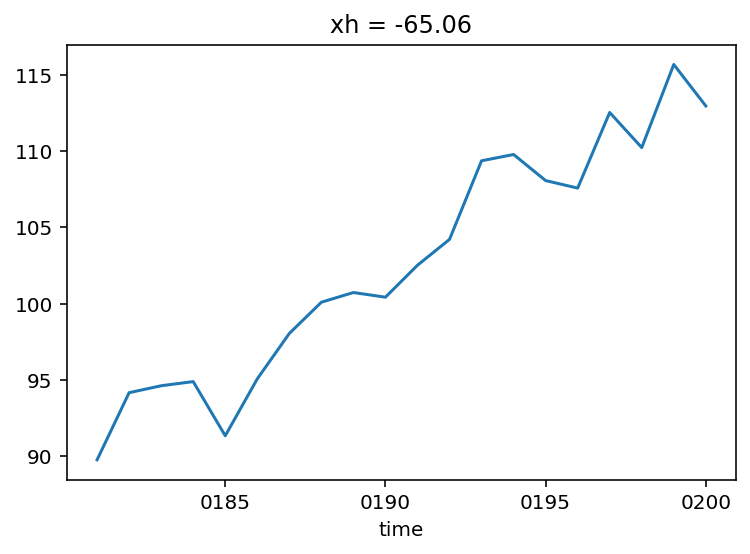

In [24]:
TWT_207_constanthk_annual_mean.plot()

In [22]:
static_sliced_om4p125 = slice_static_array(rho_odiv_183_184,static_om4p125)
#static_sliced_om4p25 = slice_static_array(rho_odiv_170,static_om4p25)

grid_sliced_p125 = Grid(static_sliced_om4p125, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

#grid_sliced_p25 = Grid(static_sliced_om4p25, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        }, periodic=['X'])

# There is an issue with the xh and xq nominal coordinates here -- adjustment is needed
# before defining the grid object for the om4p125 configurations.
# We replace the nominal xq and yh by indices so that Xarray does not get confused.
# We never need xq and yq for actual calculations, so filling these arrays with any value
# will not going to change any results.

static_om4p125_newidx = static_om4p125.copy()
static_om4p125_newidx["xh"] = xr.DataArray(np.arange(len(static_om4p125["xh"])), dims=["xh"])
static_om4p125_newidx["xq"] = xr.DataArray(np.arange(len(static_om4p125["xq"])), dims=["xq"])
static_om4p125_newidx["yh"] = xr.DataArray(np.arange(len(static_om4p125["yh"])), dims=["yh"])
static_om4p125_newidx["yq"] = xr.DataArray(np.arange(len(static_om4p125["yq"])), dims=["yq"])

grid_full_p125 = Grid(static_om4p125_newidx, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

#grid_full_p25 = Grid(static_om4p25, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        }, periodic=['X'])

In [46]:
### Compute all transports
TWT_170 = compute_thermal_wind(static_sliced_om4p25,rho_odiv_170,odiv_170,grid_sliced_p25)
BVT_170 = compute_bottom_velocity_transport(static_om4p25,odiv_170.uo,odiv_170,grid_full_p25)
SUM_TWT_BVT_170 = BVT_170[1] + TWT_170[1]
Total_UO_170 = compute_transport_from_velocity(static_om4p25,odiv_170.uo,odiv_170,grid_full_p25).squeeze()
Total_UO_SV_170 = Total_UO_170.sum(dim=['yh','z_l'])/10**6
Total_UMO_170 = odiv_170.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_170_annual_mean = annual_mean(TWT_170[1])
BVT_170_annual_mean = annual_mean(BVT_170[1])
SUM_TWT_BVT_170_annual_mean = annual_mean(SUM_TWT_BVT_170)
Total_UO_SV_170_annual_mean = annual_mean(Total_UO_SV_170)
Total_UMO_170_annual_mean = annual_mean(Total_UMO_170)

In [35]:
### Compute all transports
TWT_183_184 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_183_184,odiv_183_184,grid_sliced_p125)
BVT_183_184 = compute_bottom_velocity_transport(static_om4p125,odiv_183_184.uo,odiv_183_184,grid_full_p125)
SUM_TWT_BVT = BVT_183_184[1] + TWT_183_184[1]
Total_UO = compute_transport_from_velocity(static_om4p125,odiv_183_184.uo,odiv_183_184,grid_full_p125).squeeze()
Total_UO_SV = Total_UO.sum(dim=['yh','z_l'])/10**6
Total_UMO = odiv_183_184.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_183_184_annual_mean = annual_mean(TWT_183_184[1])
BVT_183_184_annual_mean = annual_mean(BVT_183_184[1])
SUM_TWT_BVT_annual_mean = annual_mean(SUM_TWT_BVT)
Total_UO_SV_annual_mean = annual_mean(Total_UO_SV)
Total_UMO_annual_mean = annual_mean(Total_UMO)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_170_annual_mean.plot(color='k',linestyle='--')
Total_UMO_170_annual_mean.plot(color='k')
BVT_170_annual_mean.plot(color='red')
TWT_170_annual_mean.plot(color='blue')
SUM_TWT_BVT_170_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

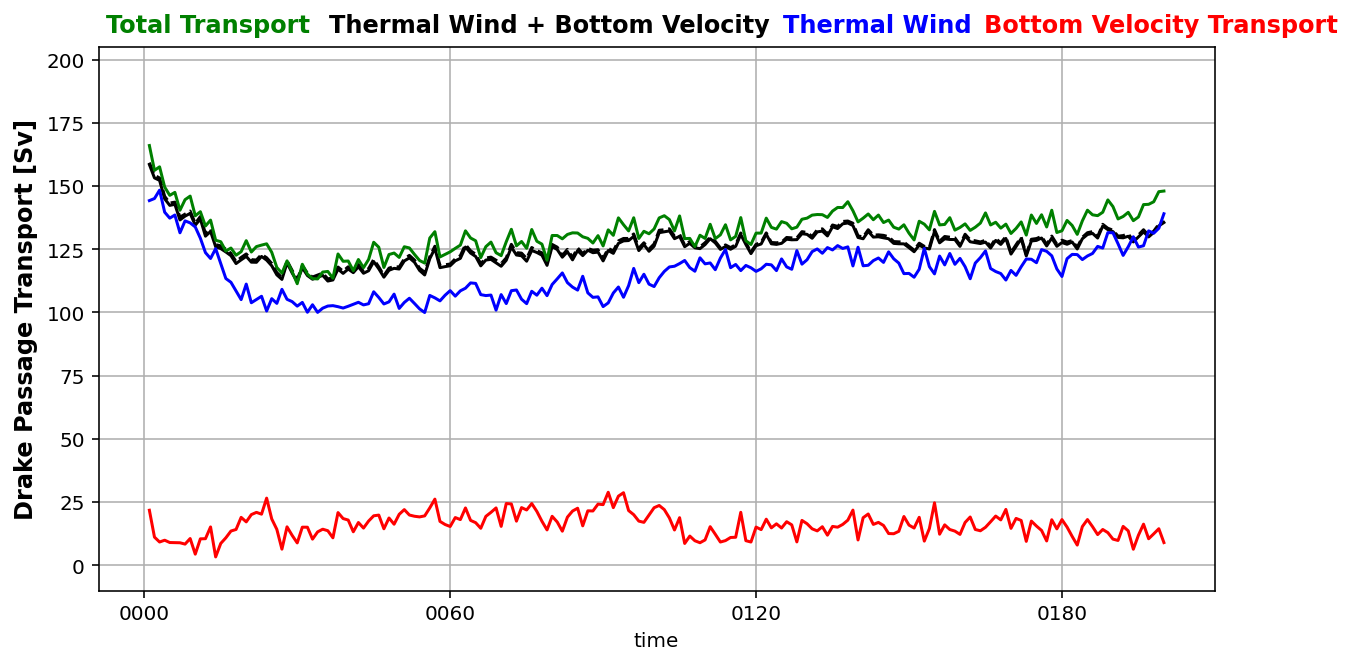

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_annual_mean.plot(color='k',linestyle='--')
Total_UMO_annual_mean.plot(color='k')
BVT_183_184_annual_mean.plot(color='red')
TWT_183_184_annual_mean.plot(color='blue')
SUM_TWT_BVT_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('Odiv-183/4')

### Compute Thermal Wind Transport (TWT) and Bottom Velocity Transport for Odiv-191

In [16]:
### Compute all transports
TWT_191 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_191,odiv_191,grid_sliced_p125)
BVT_191 = compute_bottom_velocity_transport(static_om4p125,odiv_191.uo,odiv_191,grid_full_p125)
SUM_TWT_BVT_191 = BVT_191[1] + TWT_191[1]
Total_UO_191 = compute_transport_from_velocity(static_om4p125,odiv_191.uo,odiv_191,grid_full_p125).squeeze()
Total_UO_SV_191 = Total_UO_191.sum(dim=['yh','z_l'])/10**6
Total_UMO_191 = odiv_191.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_191_annual_mean = annual_mean(TWT_191[1])
BVT_191_annual_mean = annual_mean(BVT_191[1])
SUM_TWT_BVT_191_annual_mean = annual_mean(SUM_TWT_BVT_191)
Total_UO_SV_191_annual_mean = annual_mean(Total_UO_SV_191)
Total_UMO_191_annual_mean = annual_mean(Total_UMO_191)

Text(0.5, 1.0, 'Odiv-191')

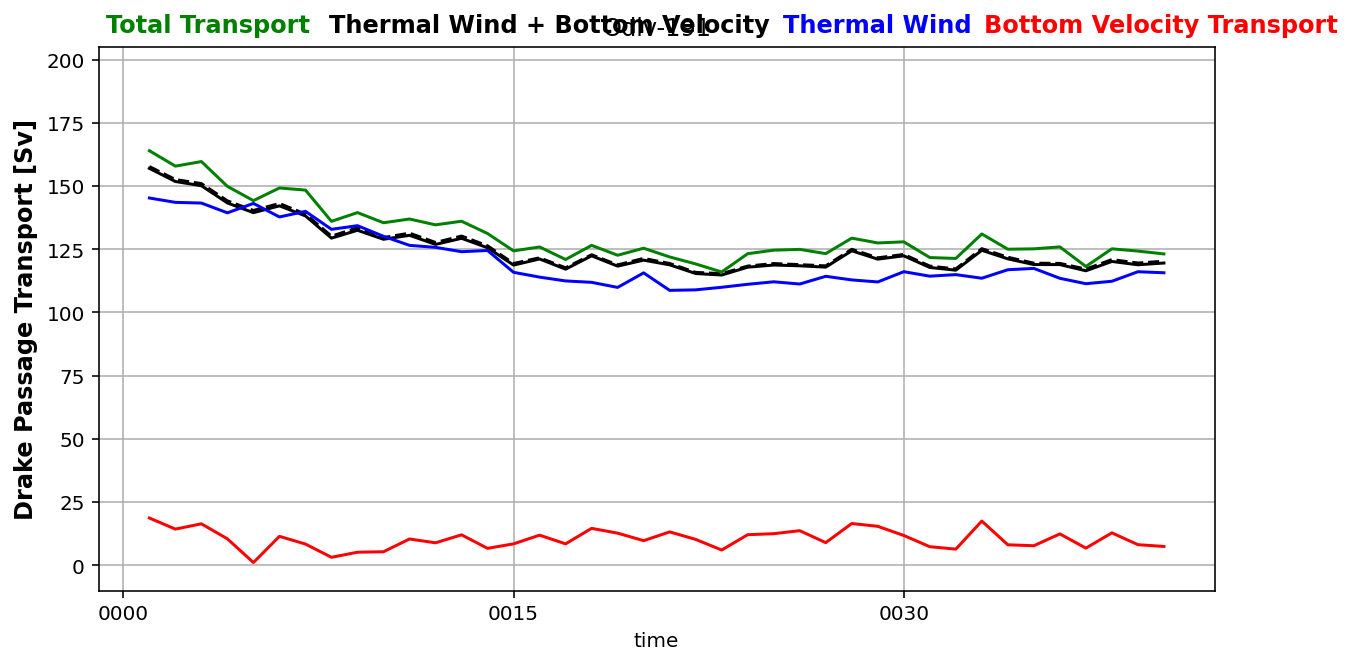

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_191_annual_mean.plot(color='k',linestyle='--')
Total_UMO_191_annual_mean.plot(color='k')
BVT_191_annual_mean.plot(color='red')
TWT_191_annual_mean.plot(color='blue')
SUM_TWT_BVT_191_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [21]:
### Compute all transports
TWT_200 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_200,odiv_200,grid_sliced_p125)
BVT_200 = compute_bottom_velocity_transport(static_om4p125,odiv_200.uo,odiv_200,grid_full_p125)
SUM_TWT_BVT_200 = BVT_200[1] + TWT_200[1]
Total_UO_200 = compute_transport_from_velocity(static_om4p125,odiv_200.uo,odiv_200,grid_full_p125).squeeze()
Total_UO_SV_200 = Total_UO_200.sum(dim=['yh','z_l'])/10**6
Total_UMO_200 = odiv_200.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_200_annual_mean = annual_mean(TWT_200[1])
BVT_200_annual_mean = annual_mean(BVT_200[1])
SUM_TWT_BVT_200_annual_mean = annual_mean(SUM_TWT_BVT_200)
Total_UO_SV_200_annual_mean = annual_mean(Total_UO_SV_200)
Total_UMO_200_annual_mean = annual_mean(Total_UMO_200)

Text(0.5, 1.0, '')

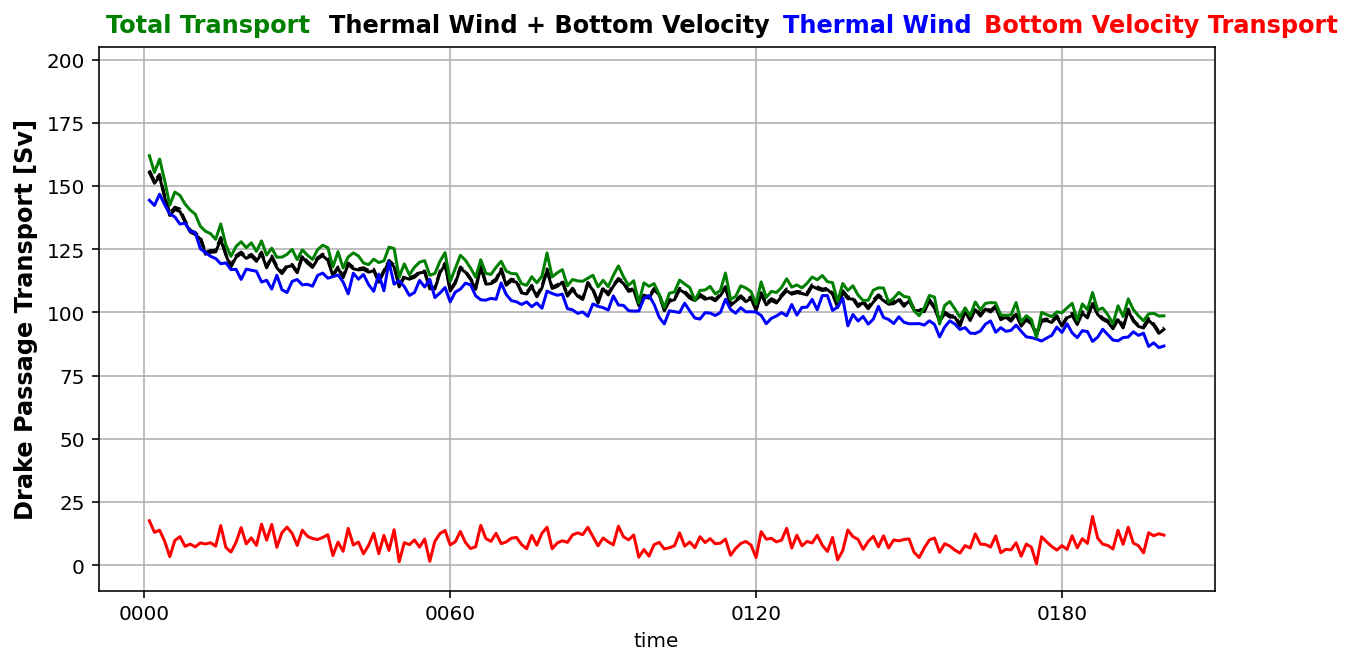

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_200_annual_mean.plot(color='k',linestyle='--')
Total_UMO_200_annual_mean.plot(color='k')
BVT_200_annual_mean.plot(color='red')
TWT_200_annual_mean.plot(color='blue')
SUM_TWT_BVT_200_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [23]:
### Compute all transports
TWT_206 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_206,odiv_206,grid_sliced_p125)
BVT_206 = compute_bottom_velocity_transport(static_om4p125,odiv_206.uo,odiv_206,grid_full_p125)
SUM_TWT_BVT_206 = BVT_206[1] + TWT_206[1]
Total_UO_206 = compute_transport_from_velocity(static_om4p125,odiv_206.uo,odiv_206,grid_full_p125).squeeze()
Total_UO_SV_206 = Total_UO_206.sum(dim=['yh','z_l'])/10**6
Total_UMO_206 = odiv_206.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_206_annual_mean = annual_mean(TWT_206[1])
BVT_206_annual_mean = annual_mean(BVT_206[1])
SUM_TWT_BVT_206_annual_mean = annual_mean(SUM_TWT_BVT_206)
Total_UO_SV_206_annual_mean = annual_mean(Total_UO_SV_206)
Total_UMO_206_annual_mean = annual_mean(Total_UMO_206)

Text(0.5, 1.0, '')

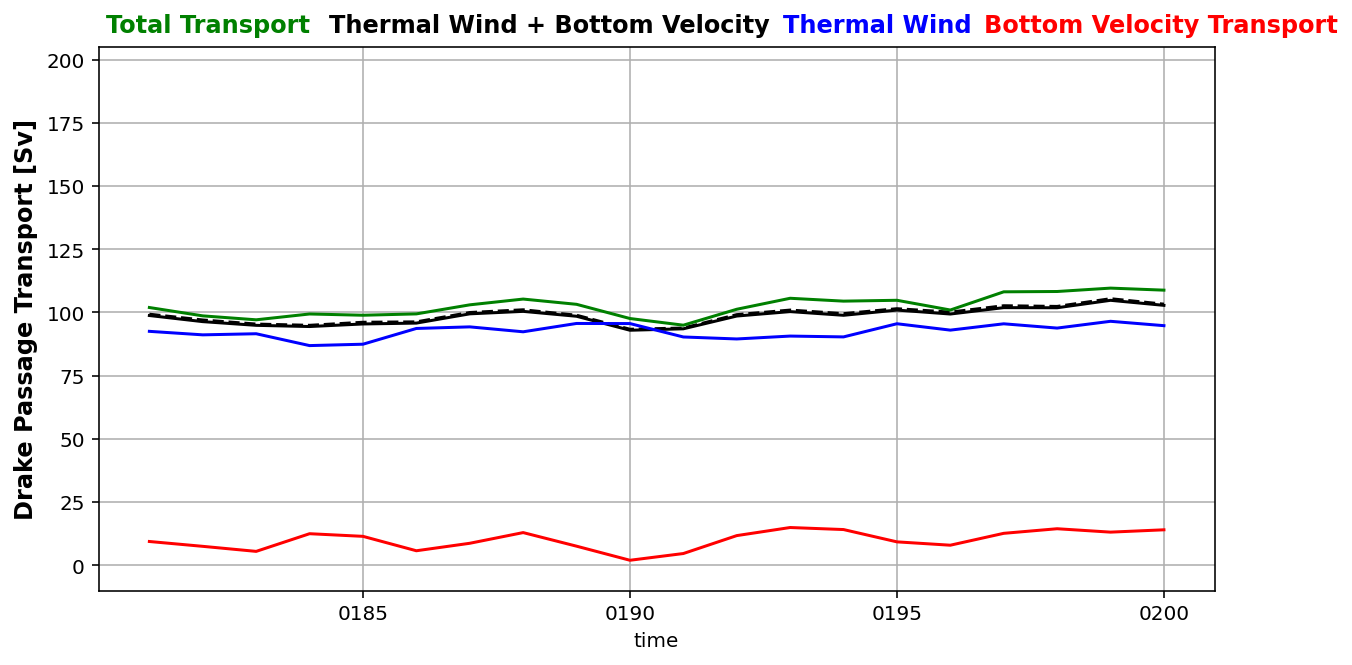

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_206_annual_mean.plot(color='k',linestyle='--')
Total_UMO_206_annual_mean.plot(color='k')
BVT_206_annual_mean.plot(color='red')
TWT_206_annual_mean.plot(color='blue')
SUM_TWT_BVT_206_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [38]:
### Compute all transports
TWT_207 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_207,odiv_207,grid_sliced_p125)
BVT_207 = compute_bottom_velocity_transport(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125)
SUM_TWT_BVT_207 = BVT_207[1] + TWT_207[1]
Total_UO_207 = compute_transport_from_velocity(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125).squeeze()
Total_UO_SV_207 = Total_UO_207.sum(dim=['yh','z_l'])/10**6
Total_UMO_207 = odiv_207.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_207_annual_mean = annual_mean(TWT_207[1])
BVT_207_annual_mean = annual_mean(BVT_207[1])
SUM_TWT_BVT_207_annual_mean = annual_mean(SUM_TWT_BVT_207)
Total_UO_SV_207_annual_mean = annual_mean(Total_UO_SV_207)
Total_UMO_207_annual_mean = annual_mean(Total_UMO_207)

Text(0.5, 1.0, '')

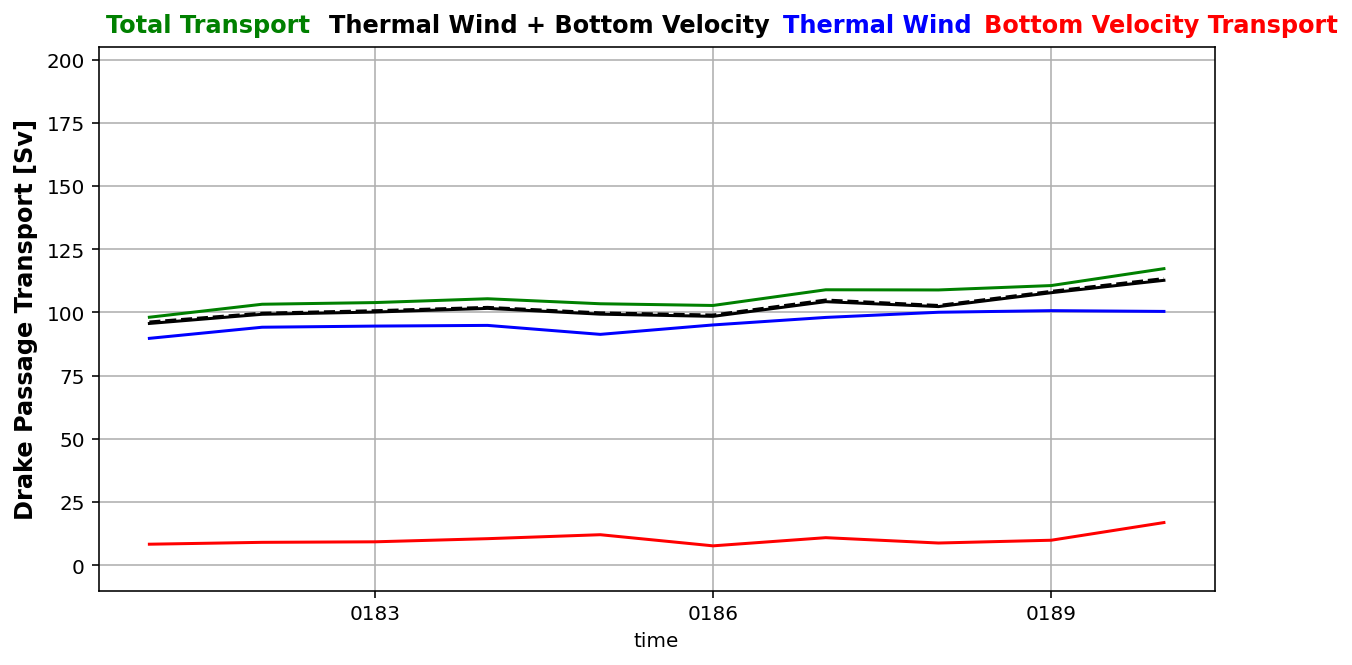

In [39]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_207_annual_mean.plot(color='k',linestyle='--')
Total_UMO_207_annual_mean.plot(color='k')
BVT_207_annual_mean.plot(color='red')
TWT_207_annual_mean.plot(color='blue')
SUM_TWT_BVT_207_annual_mean.plot(color='green')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [40]:
### Compute all transports
TWT_170 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_170,odiv_170,grid_sliced_p125)
BVT_170 = compute_bottom_velocity_transport(static_om4p125,odiv_170.uo,odiv_170,grid_full_p125)
SUM_TWT_BVT_170 = BVT_170[1] + TWT_170[1]
Total_UO_170 = compute_transport_from_velocity(static_om4p125,odiv_170.uo,odiv_170,grid_full_p125).squeeze()
Total_UO_SV_170 = Total_UO_170.sum(dim=['yh','z_l'])/10**6
Total_UMO_170 = odiv_170.umo.sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_170_annual_mean = annual_mean(TWT_170[1])
BVT_170_annual_mean = annual_mean(BVT_170[1])
SUM_TWT_BVT_170_annual_mean = annual_mean(SUM_TWT_BVT_170)
Total_UO_SV_170_annual_mean = annual_mean(Total_UO_SV_170)
Total_UMO_170_annual_mean = annual_mean(Total_UMO_170)

ValueError: conflicting sizes for dimension 'yq': length 139 on the data but length 292 on coordinate 'yq'

NameError: name 'BVT_183_184_annual_mean' is not defined

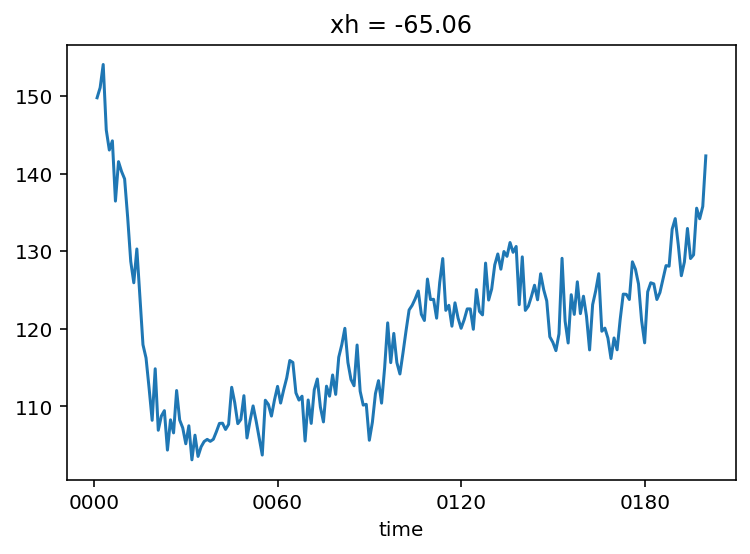

In [96]:
TWT_183_184_annual_mean.plot()
BVT_183_184_annual_mean.plot()

In [280]:
## Create xgcm grid objects
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions
grid_p125 = Grid(static_sliced_om4p125, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

#grid_p25 = Grid(odiv_170, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

In [297]:
f = grid_p125.interp(static_sliced_om4p125.Coriolis,'X',boundary='fill').sel(xh=rho_odiv_183_184.xh.values,method='nearest')
diff_dens = grid_p125.diff(rho_odiv_183_184,'Y',boundary='fill')
dy = static_sliced_om4p125.dyCv.sel(xh=rho_odiv_183_184.xh.values,method='nearest')
ddens_dy = (diff_dens/dy)
thk = ml.derived.calc_dz(odiv_183_184.z_l,odiv_183_184.z_i,static_sliced_om4p125.deptho)
thk = thk.where(thk>0).sel(xh=rho_odiv_183_184.xh.values,method='nearest')
thk_interp = grid_p125.interp(thk,'Y',boundary='fill')

#dz_u_points = compute_dz_between_u_points(thk_interp)
dz_u_points = thk_interp

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f)

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   
ugeo_183 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_183*thk_interp*dy)/10**6
TWT_183_184 = U_Sv.sum(dim=(['yq','z_l']))
#BC_T_183_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
#BC_T_183_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/nbhome/Rebecca.Beadling/miniconda/envs/py39/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


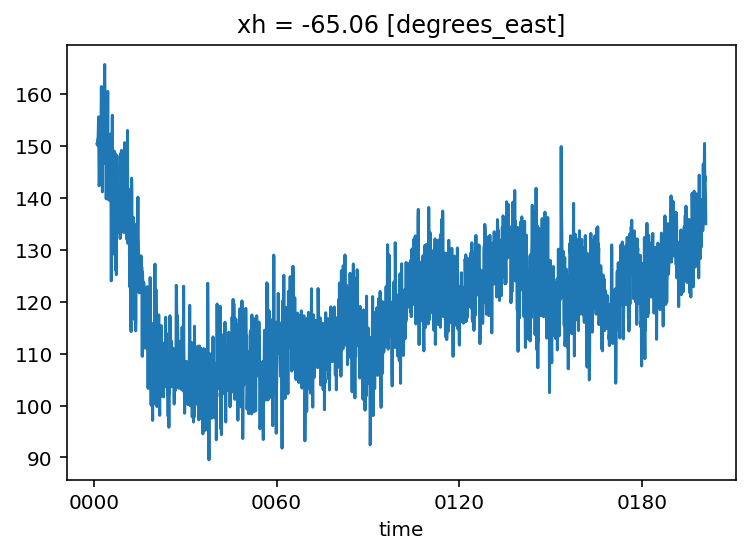

In [295]:
TWT_183.plot()

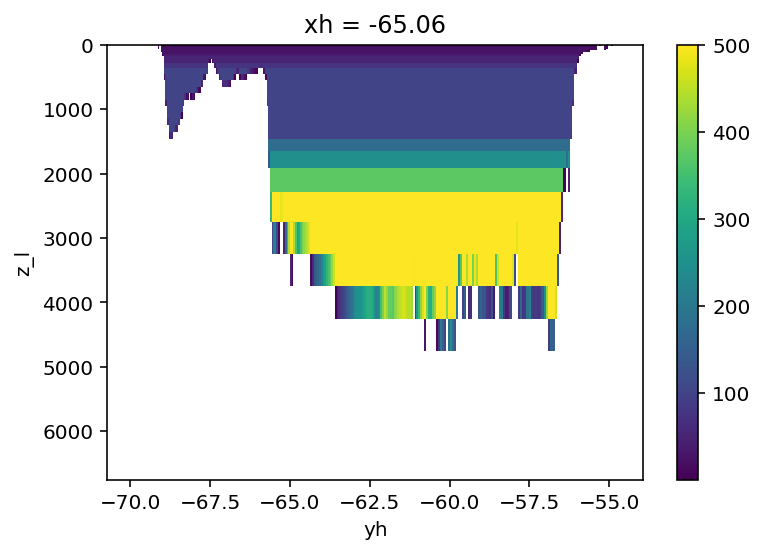

In [296]:
thk.plot(yincrease=False)

### Compute Thermal Wind Transport om4p125

In [ ]:
### Interpolate Coriolis Parameter onto U point because this is where ddens_dy is located in the next step:
f = grid_p125.interp(static_sliced_om4p125.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-54)).sel(xh=-65,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_183 = pdens(cm4_183_salt.so,cm4_183_temp.thetao,local=True).squeeze()
diff_dens = grid_183.diff(pdens_183,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_183.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello
### and areacello, which are located on the tracer cell points (xh,yh)
thk_183 = cm4_183_vol.volcello.isel(time=0) / cm4_static_183.areacello.sel(yh=slice(-70.69,-53.93)).sel(xh=-65,method='nearest')
thk_183 = grid_183.interp(thk_183,'Y',boundary='fill')
thk_Drake = thk_183.sel(yq=slice(-70.69,-53.85)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   
ugeo_183 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')


### Compute total transport, U:
U_Sv = (ugeo_183*thk_183*cm4_static_183.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest'))/10**6
BC_T_183 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_183_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_183_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

<xarray.Dataset>
Dimensions:       (z_l: 35, z_i: 36, yq: 292, xq: 2881, yh: 291, xh: 2880)
Coordinates:
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * xh            (xh) float64 -298.6 -298.5 -298.4 -298.3 ... 61.05 61.16 61.28
  * xq            (xq) float64 -298.5 -298.4 -298.3 -298.2 ... 61.23 61.35 61.35
  * yh            (yh) float64 -70.69 -70.64 -70.59 ... -54.13 -54.05 -53.98
  * yq            (yq) float64 -70.66 -70.61 -70.56 ... -54.02 -53.94 -53.87
Data variables: (12/26)
    Coriolis      (z_l, z_i, yq, xq) float32 -0.0001376 ... -0.0001179
    areacello     (z_l, z_i, yh, xh) float32 2.509e+07 2.509e+07 ... 6.681e+07
    areacello_bu  (z_l, z_i, yq, xq) float32 2.512e+07 2.512e+07 ... 6.693e+07
    areacello_cu  (z_l, z_i, yh, xq) float32 0.0 0.0 0.0 ... 6.681e+07 6.681e+07
    areacello_cv  (z_l, z_i, yq, xh) float32 0.0 0.0 0.0 ... 6.717e+07 6.717e+07
    deptho        (z_l, z_i, yh, xh) float32 nan nan nan ... 4.741e+03 4.615e+03
    ...            ...
    hfgeou        (z_l, z_i, yh, xh) float32 0.0 0.0 0.0 ... 0.06339 0.06339
    sftof         (z_l, z_i, yh, xh) float32 0.0 0.0 0.0 ... 100.0 100.0 100.0
    wet           (z_l, z_i, yh, xh) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    wet_c         (z_l, z_i, yq, xq) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    wet_u         (z_l, z_i, yh, xq) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    wet_v         (z_l, z_i, yq, xh) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    external_variables:  areacello areacello

In [221]:
grid_p125 = Grid(static_om4p125_with_z.isel(yq=slice(yq_south_idx.values,yq_north_idx.values + 2)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])
diff_dens = grid_p125.diff(rho_odiv_183_184,'Y',boundary='fill')


In [224]:
diff_dens

<xarray.DataArray 'sub-dd7d3c0f78d5849460b4041b29ddce38' (time: 2400, z_l: 35, yq: 292)>
dask.array<sub, shape=(2400, 35, 292), dtype=float64, chunksize=(120, 35, 290), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0200-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -70.66 -70.61 -70.56 -70.52 ... -54.02 -53.94 -53.87

<xarray.DataArray ()>
array(288)
Coordinates:
    xh       float64 -65.06
    yh       float64 -70.69

array(-70.663)

<xarray.DataArray 'yh' ()>
array(-70.6385)
Coordinates:
    xh       float64 -65.06
    yh       float64 -70.64

<xarray.DataArray 'yq' ()>
array(-70.61393614)
Coordinates:
    yq       float64 -70.61
Attributes:
    long_name:  q point nominal latitude
    units:      degrees_north
    axis:       Y

array(289)

(array(-70.6875514), array(-53.97906377))

In [77]:
#static_om4p125_with_z.Coriolis

In [80]:
len(rho_odiv_183_184.yh)

291

In [78]:
diff_dens = grid_p125.diff(rho_odiv_183_184,'Y',boundary='fill')

ValueError: conflicting sizes for dimension 'yq': length 292 on the data but length 2241 on coordinate 'yq'

In [7]:
## Create xgcm grid object
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## our static file has to be sliced here since we are using the Drake cross-section model output
grid_170 = Grid(cm4_static_170.sel(yh=slice(-70.35,-54.49),yq=slice(-70.50,-54.30)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where ddens_dy is located in the next step:
f_V = grid_170.interp(cm4_static_170.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-55)).sel(xh=-69.90,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_170 = pdens(cm4_170_salt.so,cm4_170_temp.thetao,local=True).squeeze()
diff_dens = grid_170.diff(pdens_170,'Y',boundary='fill')

### Compute Geostrophic Velocity assuming 0 bottom velocity:
1. Compute sigma 0 field (sigma 0 - 1000 is returned)
2. Interpolate Coriolis parameter onto the yq, xh point. This is where my diff_dens ends up after applying a grid.diff()
3. Using xgcm to compute a discrete difference of density along the y (lat) axis. This is diff_dens and the points are now located on yq,xh points, not yh,xh. We use boundary = 'fill' here to set values outside of the array boundary to fill_value (i.e., Dirichlet boundary condition (fixed boundary condition)). 
4. Compute dz_Drake ... in this case this is equivalent to our cell thickness. Cell thickness is on yh,xh points so we interpolate to yq,xh
5. We want the distance between our tracer points, since this is where our potential density is defined on (not diff_dens) This is equivalent to the width of the v cell which is given in the cm4 static file as dyCv with dimensions yq,xh. This is our dy.
6. Compute (ddens_dy)*dz and cumulatively sum vertically to get the geostrophic velocity
7. Convert geostrophic velocity to a volume transport using dyCv * dz_Drake and sum. For time=0, For Odiv170 this calculation gives me 95.67 Sv. This value does not depend on what I use for my boundary types in my interp or diff calls.

### Baroclinic Transport for Odiv-170

In [9]:
## Create xgcm grid object
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## our static file has to be sliced here since we are using the Drake cross-section model output
grid_170 = Grid(cm4_static_170.sel(yh=slice(-70.35,-54.49),yq=slice(-70.50,-54.30)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where ddens_dy is located in the next step:
f_V = grid_170.interp(cm4_static_170.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-55)).sel(xh=-69.90,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_170 = pdens(cm4_170_salt.so,cm4_170_temp.thetao,local=True).squeeze()
diff_dens = grid_170.diff(pdens_170,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_170.dyCv.sel(yq=slice(-70.50,-54.30)).sel(xh=-69.90,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello and areacello, 
### which are located on the tracer cell points (xh,yh)
thk_170 = cm4_170_vol.volcello.isel(time=0) / cm4_static_170.areacello.sel(yh=slice(-70.40,-54.49)).sel(xh=-69.90,method='nearest')
thk_170 = grid_170.interp(thk_170,'Y',boundary='fill')
thk_Drake = thk_170.sel(yq=slice(-70,-55)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   
ugeo_170 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_170*thk_170*cm4_static_170.dyCv.sel(yq=slice(-70,-55.14)))/10**6
BC_T_170 = U_Sv.sel(xh=-69.90,method='nearest').sum(dim=(['yq','z_l']))
BC_T_170_upper1000 = U_Sv.sel(xh=-69.90,method='nearest').reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_170_below1000 = U_Sv.sel(xh=-69.90,method='nearest').reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Baroclinic Transport for Odiv-183

In [10]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## Note for 184, 69W is at nominal yq=-65

grid_183 = Grid(cm4_static_183.sel(yh=slice(-70.69,-53.93),yq=slice(-70.69,-53.85)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parameter onto U point because this is where ddens_dy is located in the next step:
f_V = grid_183.interp(cm4_static_183.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-54)).sel(xh=-65,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_183 = pdens(cm4_183_salt.so,cm4_183_temp.thetao,local=True).squeeze()
diff_dens = grid_183.diff(pdens_183,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_183.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello
### and areacello, which are located on the tracer cell points (xh,yh)
thk_183 = cm4_183_vol.volcello.isel(time=0) / cm4_static_183.areacello.sel(yh=slice(-70.69,-53.93)).sel(xh=-65,method='nearest')
thk_183 = grid_183.interp(thk_183,'Y',boundary='fill')
thk_Drake = thk_183.sel(yq=slice(-70.69,-53.85)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   
ugeo_183 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_183*thk_183*cm4_static_183.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest'))/10**6
BC_T_183 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_183_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_183_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Baroclinic Transport for Odiv-184

In [11]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## Note for 184, 69W is at yq=65

grid_184 = Grid(cm4_static_184.sel(yh=slice(-70.69,-53.93),yq=slice(-70.69,-53.85)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where ddens_dy is located in the next step:
f_V = grid_184.interp(cm4_static_184.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-54)).sel(xh=-65,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_184 = pdens(cm4_184_salt.so,cm4_184_temp.thetao,local=True).squeeze()
diff_dens = grid_184.diff(pdens_184,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_184.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello
### and areacello, which are located on the tracer cell points (xh,yh)
thk_184 = cm4_183_vol.volcello.isel(time=0) / cm4_static_183.areacello.sel(yh=slice(-70.69,-53.93)).sel(xh=-65,method='nearest')
thk_184 = grid_183.interp(thk_184,'Y',boundary='fill')
thk_Drake = thk_184.sel(yq=slice(-70.69,-53.85)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   ### So when rho1 > rho0, ddens_dy = -1 * -constant, so ugeo_interm
ugeo_184 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_184*thk_184*cm4_static_184.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest'))/10**6
BC_T_184 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_184_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_184_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Baroclinic Transport for Odiv-191

In [12]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## Note for 184, 69W is at yq=65

grid_191 = Grid(cm4_static_191.sel(yh=slice(-70.69,-53.93),yq=slice(-70.69,-53.85)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where ddens_dy is located in the next step:
f_V = grid_191.interp(cm4_static_191.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-54)).sel(xh=-65,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_191 = pdens(cm4_191_salt.so,cm4_191_temp.thetao,local=True).squeeze()
diff_dens = grid_191.diff(pdens_191,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_191.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello
### and areacello, which are located on the tracer cell points (xh,yh)
thk_191 = cm4_191_vol.volcello.isel(time=0) / cm4_static_191.areacello.sel(yh=slice(-70.69,-53.93)).sel(xh=-65,method='nearest')
thk_191 = grid_191.interp(thk_191,'Y',boundary='fill')
thk_Drake = thk_191.sel(yq=slice(-70.69,-53.85)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   ### So when rho1 > rho0, ddens_dy = -1 * -constant, so ugeo_interm
ugeo_191 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_191*thk_191*cm4_static_191.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest'))/10**6
BC_T_191 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_191_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_191_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

NameError: name 'cm4_static_191' is not defined

### Baroclinic Transport for Odiv-200

In [13]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
## Note for 184, 69W is at yq=65

grid_200 = Grid(cm4_static_200.sel(yh=slice(-70.69,-53.93),yq=slice(-70.69,-53.85)), 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where ddens_dy is located in the next step:
f_V = grid_200.interp(cm4_static_200.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-54)).sel(xh=-65,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_200 = pdens(cm4_200_salt.so,cm4_200_temp.thetao,local=True).squeeze()
diff_dens = grid_200.diff(pdens_200,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_static_200.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest') 
ddens_dy = diff_dens/dy

### Compute grid cell thickness to account for partial cells using volcello
### and areacello, which are located on the tracer cell points (xh,yh)
thk_200 = cm4_200_vol.volcello.isel(time=0) / cm4_static_200.areacello.sel(yh=slice(-70.69,-53.93)).sel(xh=-65,method='nearest')
thk_200 = grid_200.interp(thk_200,'Y',boundary='fill')
thk_Drake = thk_200.sel(yq=slice(-70.69,-53.85)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake)             

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   ### So when rho1 > rho0, ddens_dy = -1 * -constant, so ugeo_interm
ugeo_200 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_200*thk_200*cm4_static_200.dyCv.sel(yq=slice(-70.69,-53.85)).sel(xh=-65,method='nearest'))/10**6
BC_T_200 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_200_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_200_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Baroclinic Transport for CMIP6 CM4

In [ ]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
### cmip6 esm4 and cm4 are in non symmetric mode:
grid_cmip6_cm4 = Grid(cm4_cmip6_static.sel(yh=slice(-70,-54.49),yq=slice(-70,-54.49)),
                      coords={'X': {'center': 'xh', 'right': 'xq'},
                              'Y': {'center': 'yh', 'right': 'yq'}, 
                              'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])
### Interpolate Coriolis Parametrer onto U point because this is where drho/dy will end up
### after differencing:
f_V = grid_cmip6_cm4.interp(cm4_cmip6_static.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-55)).sel(xh=-69.90,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_cm4_cmip6 = pdens(cm4_cmip6_salt.so,cm4_cmip6_temp.thetao,local=True).squeeze()
diff_dens = grid_cmip6_cm4.diff(pdens_cm4_cmip6,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = cm4_cmip6_static.dyCv.sel(yq=slice(-70.50,-54.30)).sel(xh=-69.90,method='nearest') 
ddens_dy = diff_dens/dy

### dz_Drake .... equivalent to cell thickness
thk_cm4 = cm4_cmip6_vol.volcello.isel(time=0) / cm4_cmip6_static.areacello.sel(yh=slice(-69.95,-54.49)).sel(xh=-69.90,method='nearest')
thk_cm4 = grid_cmip6_cm4.interp(thk_cm4,'Y',boundary='fill')
thk_Drake = thk_cm4.sel(yq=slice(-70,-55)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake) 

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   ### So when rho1 > rho0, ddens_dy = -1 * -constant, so ugeo_interm
ugeo_cm4 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_cm4*thk_cm4*cm4_cmip6_static.dyCv.sel(yq=slice(-70,-55)).sel(xh=-69.90,method='nearest'))/10**6
BC_T_cm4_cmip6 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_cm4_cmip6_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_cm4_cmip6_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Baroclinic Transport for CMIP6 ESM4

In [14]:
## Create xgcm grid objects for each model:
## symmetric mode (xq and xh have different dimensions & yq and yh have different dimensions)
### cmip6 esm4 and cm4 are in non symmetric mode:
grid_cmip6_esm4 = Grid(esm4_cmip6_static.sel(yh=slice(-70.95,-54.49),yq=slice(-70.95,-54.30)),
                      coords={'X': {'center': 'xh', 'right': 'xq'},
                              'Y': {'center': 'yh', 'right': 'yq'}, 
                              'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### Interpolate Coriolis Parametrer onto U point because this is where drho/dy will end up
### after differencing:
f_V = grid_cmip6_esm4.interp(esm4_cmip6_static.Coriolis,'X',boundary='fill')
f_V_Drake = f_V.sel(yq=slice(-70,-55)).sel(xh=-69.90,method='nearest')

### Compute the discrete difference of density along the Y axis.
pdens_esm4_cmip6 = pdens(esm4_cmip6_salt.so,esm4_cmip6_temp.thetao,local=True).squeeze()
diff_dens = grid_cmip6_esm4.diff(pdens_esm4_cmip6,'Y',boundary='fill')

## We want the distance between our Tracer (h) points which is equivalent to the width of the v cell:
## which is given in the cm4 static file as dxCv with dimensions yq,xh:
dy = esm4_cmip6_static.dyCv.sel(yq=slice(-70.50,-54.30)).sel(xh=-69.90,method='nearest')  
ddens_dy = diff_dens/dy

### dz_Drake .... equivalent to cell thickness
thk_esm4 = esm4_cmip6_vol.volcello.isel(time=0) / esm4_cmip6_static.areacello.sel(yh=slice(-70.95,-54.49)).sel(xh=-69.90,method='nearest')
thk_esm4 = grid_cmip6_esm4.interp(thk_esm4,'Y',boundary='fill')
thk_Drake = thk_esm4.sel(yq=slice(-70.50,-54.30)).load()

dz_u_points = compute_dz_between_u_points(thk_Drake)

ddens_dy_times_dz = (ddens_dy)*dz_u_points     
constant = g / (rho_0*f_V_Drake) 

## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
ugeo_intermed = (constant*ddens_dy_times_dz).transpose("z_l","yq","time")   ### So when rho1 > rho0, ddens_dy = -1 * -constant, so ugeo_interm
ugeo_esm4 = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

### Compute total transport, U:
U_Sv = (ugeo_esm4*thk_esm4*esm4_cmip6_static.dyCv.sel(yq=slice(-70.50,-54.30)).sel(xh=-69.90,method='nearest'))/10**6
BC_T_esm4_cmip6 = U_Sv.sum(dim=(['yq','z_l']))
BC_T_esm4_cmip6_upper1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
BC_T_esm4_cmip6_below1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))

### Plot time series of annual-mean 
#### (note months are not weighted properly yet, will have to adjust)

Text(0.5, 1.0, '')

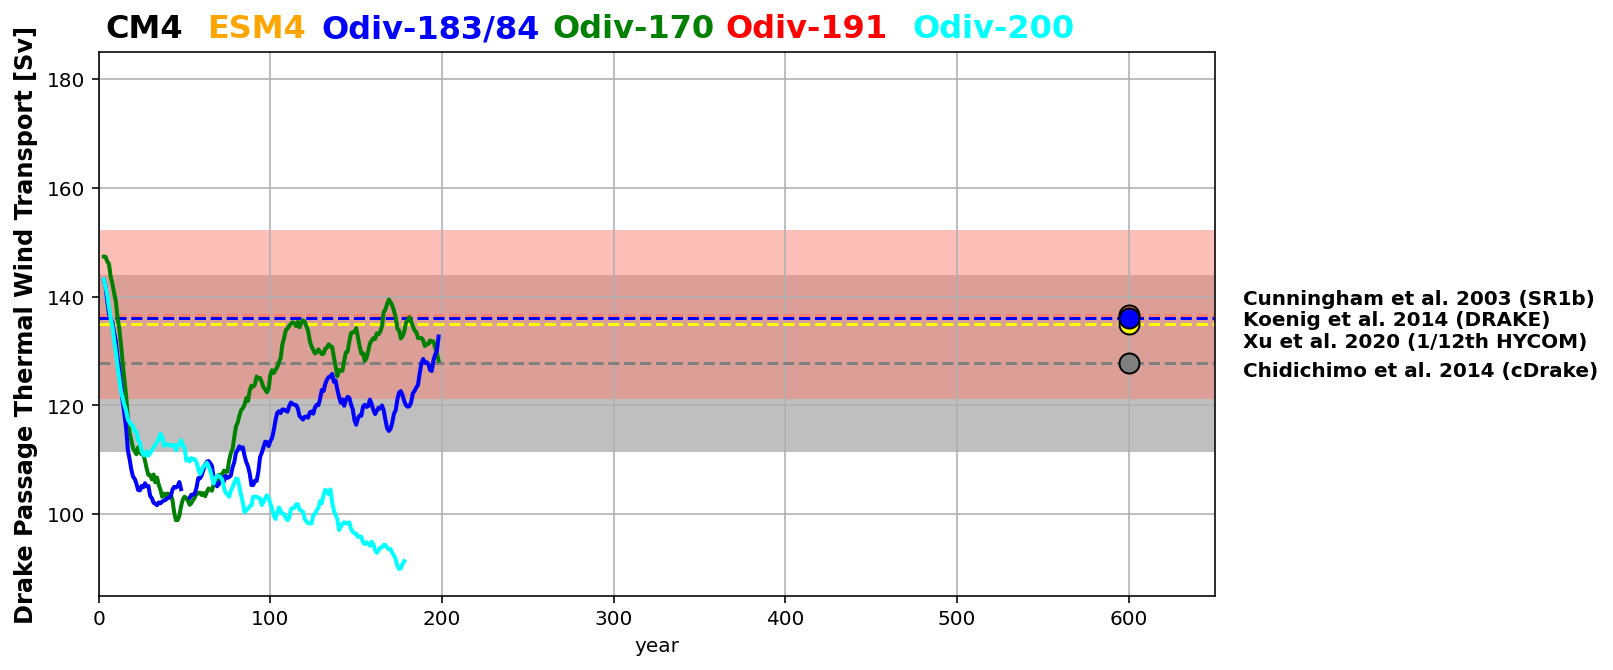

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

x_end = 600

x_all = (0,650)
y1_SR1b = (121.1)  
y2_SR1b = (152.3)
y3_SR1b = (136.7)  ## Value of 136.7 +/- 7.8 Sv (standard dev) from Cunningham et al. 2003

y_cDrake = (111.5)
y1_cDrake = (143.9)
y2_cDrake = (127.7)  ## Value of 127.7 +/- 8.1 Sv (standard dev) from Chidichimo et al. 2014

y_Xu = (135.0)
y_DRAKE = (136)

ax.fill_between(x_all,y_cDrake,y1_cDrake,facecolor='grey',alpha=0.5)
ax.fill_between(x_all,y1_SR1b,y2_SR1b,facecolor='salmon',alpha=0.5)

plt.axhline(y=127.7,linestyle='--',color='grey')
plt.axhline(y=136.7,linestyle='--',color='salmon')
plt.axhline(y=135,linestyle='--',color='yellow')
plt.axhline(y=136,linestyle='--',color='blue')

#BC_T_cm4_cmip6.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='black',linewidth=2)
BC_T_170.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='green',linewidth=2)
BC_T_184.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
BC_T_183.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
#BC_T_191.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='red',linewidth=2)
BC_T_200.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='cyan',linewidth=2)
#BC_T_esm4_cmip6.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='orange',linewidth=2)

ax.set_ylabel('Drake Passage Thermal Wind Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(85,185)
plt.xlim(0,650)

plt.plot(x_end,y2_cDrake,marker='o',markersize=10,markerfacecolor='grey',markeredgecolor='k')
plt.plot(x_end,y3_SR1b,marker='o',markersize=10,markerfacecolor='salmon',markeredgecolor='k')
plt.plot(x_end,y_Xu,marker='o',markersize=10,markerfacecolor='yellow',markeredgecolor='k')
plt.plot(x_end,y_DRAKE,marker='o',markersize=10,markerfacecolor='blue',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.20,0.90,'ESM4',fontsize=16,color='orange',fontweight='bold')
fig.text(0.28,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.44,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.56,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.69,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')

fig.text(0.92,0.43,'Chidichimo et al. 2014 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.53,'Cunningham et al. 2003 (SR1b)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.50,'Koenig et al. 2014 (DRAKE)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.47,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

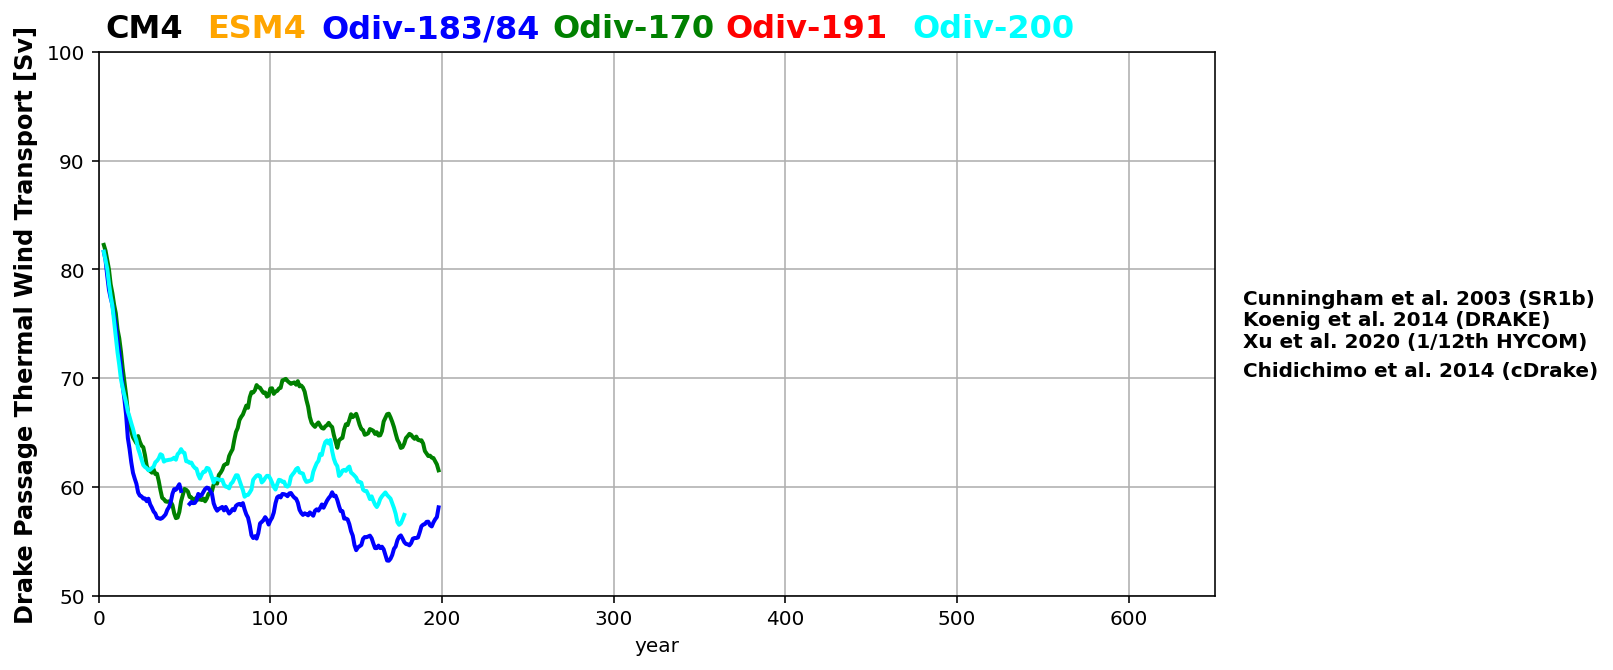

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

x_end = 600

x_all = (0,650)
y1_SR1b = (121.1)  
y2_SR1b = (152.3)
y3_SR1b = (136.7)  ## Value of 136.7 +/- 7.8 Sv (standard dev) from Cunningham et al. 2003

y_cDrake = (111.5)
y1_cDrake = (143.9)
y2_cDrake = (127.7)  ## Value of 127.7 +/- 8.1 Sv (standard dev) from Chidichimo et al. 2014

y_Xu = (135.0)
y_DRAKE = (136)

ax.fill_between(x_all,y_cDrake,y1_cDrake,facecolor='grey',alpha=0.5)
ax.fill_between(x_all,y1_SR1b,y2_SR1b,facecolor='salmon',alpha=0.5)

plt.axhline(y=127.7,linestyle='--',color='grey')
plt.axhline(y=136.7,linestyle='--',color='salmon')
plt.axhline(y=135,linestyle='--',color='yellow')
plt.axhline(y=136,linestyle='--',color='blue')

#BC_T_cm4_cmip6_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='black',linewidth=2)
BC_T_170_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='green',linewidth=2)
BC_T_184_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
BC_T_183_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
#BC_T_191_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='red',linewidth=2)
BC_T_200_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='cyan',linewidth=2)
#BC_T_esm4_cmip6_upper1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='orange',linewidth=2)

ax.set_ylabel('Drake Passage Thermal Wind Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(50,100)
plt.xlim(0,650)

plt.plot(x_end,y2_cDrake,marker='o',markersize=10,markerfacecolor='grey',markeredgecolor='k')
plt.plot(x_end,y3_SR1b,marker='o',markersize=10,markerfacecolor='salmon',markeredgecolor='k')
plt.plot(x_end,y_Xu,marker='o',markersize=10,markerfacecolor='yellow',markeredgecolor='k')
plt.plot(x_end,y_DRAKE,marker='o',markersize=10,markerfacecolor='blue',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.20,0.90,'ESM4',fontsize=16,color='orange',fontweight='bold')
fig.text(0.28,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.44,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.56,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.69,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')

fig.text(0.92,0.43,'Chidichimo et al. 2014 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.53,'Cunningham et al. 2003 (SR1b)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.50,'Koenig et al. 2014 (DRAKE)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.47,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

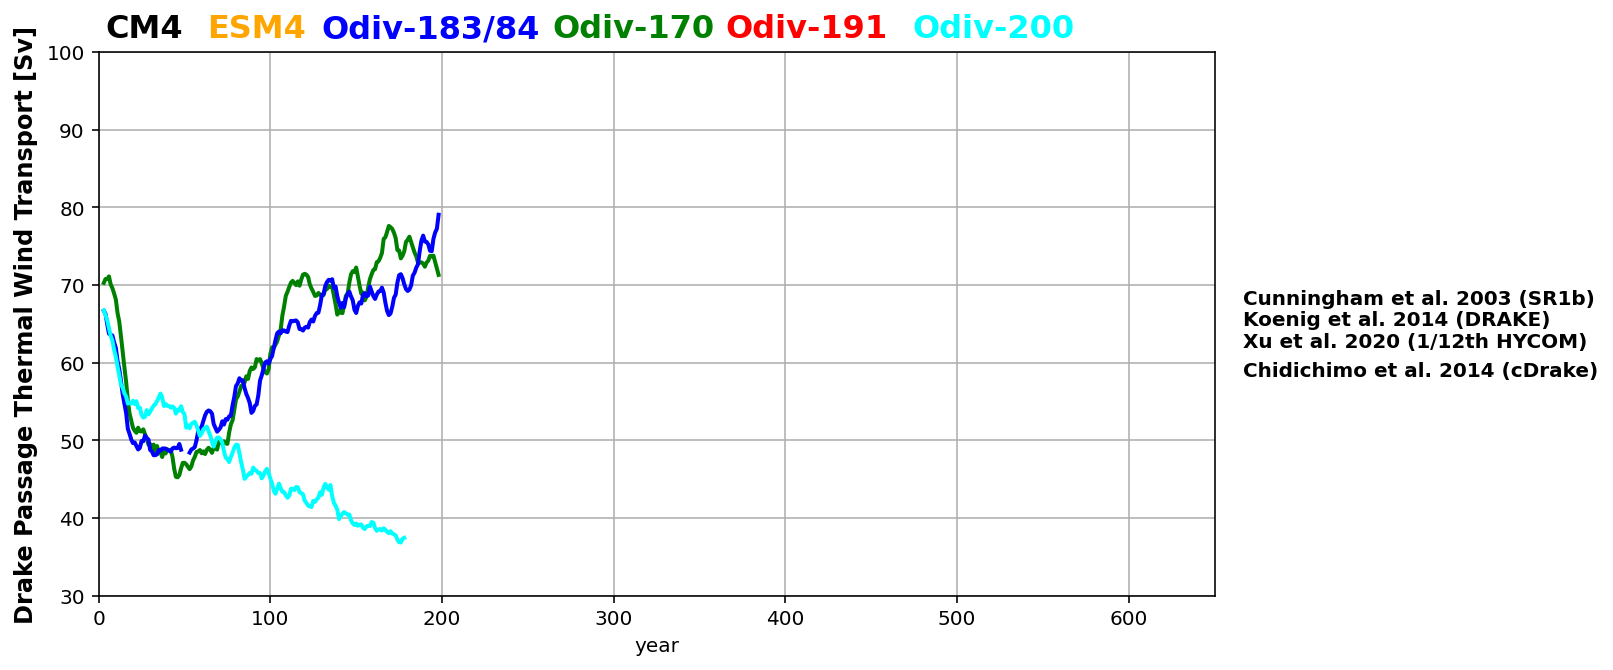

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

#BC_T_cm4_cmip6_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='black',linewidth=2)
BC_T_170_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='green',linewidth=2)
BC_T_184_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
BC_T_183_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
#BC_T_191_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='red',linewidth=2)
BC_T_200_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='cyan',linewidth=2)
#BC_T_esm4_cmip6_below1000.groupby('time.year').mean(dim='time').squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='orange',linewidth=2)

ax.set_ylabel('Drake Passage Thermal Wind Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(30,100)
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.20,0.90,'ESM4',fontsize=16,color='orange',fontweight='bold')
fig.text(0.28,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.44,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.56,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.69,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')

fig.text(0.92,0.43,'Chidichimo et al. 2014 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.53,'Cunningham et al. 2003 (SR1b)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.50,'Koenig et al. 2014 (DRAKE)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.47,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')

plt.title('')

### Compute Transport due to bottom velocities (Refered to as the "Barotropic Transport" in cDrake)

In [18]:
### Isolate bottom velocities
uo_bottom_Drake_170 = cm4_170_uo.uo.ffill('z_l').isel(z_l=-1)
uo_bottom_Drake_183 = cm4_183_uo.uo.ffill('z_l').isel(z_l=-1)
uo_bottom_Drake_184 = cm4_184_uo.uo.ffill('z_l').isel(z_l=-1)
#uo_bottom_Drake_191 = cm4_191_uo.uo.ffill('z_l').isel(z_l=-1)
uo_bottom_Drake_200 = cm4_200_uo.uo.ffill('z_l').isel(z_l=-1)
#uo_bottom_Drake_cm4_cmip6 = cm4_cmip6_uo.uo.ffill('z_l').isel(z_l=-1)
#uo_bottom_Drake_esm4_cmip6 = esm4_cmip6_uo.uo.ffill('z_l').isel(z_l=-1)

In [19]:
cm4_184_vol_full = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/ocean_month_z.005101-005512.volcello.nc',
                            combine='by_coords', use_cftime=True).isel(time=0)
cm4_184_vol_full.volcello.isel(xh=1846)

<xarray.DataArray 'volcello' (z_l: 35, yh: 2240)>
dask.array<getitem, shape=(35, 2240), dtype=float32, chunksize=(35, 2240), chunktype=numpy.ndarray>
Coordinates:
    time     object 0051-01-16 12:00:00
    xh       float64 -64.07
  * yh       (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.81 89.86 89.92 89.97
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:      Ocean grid-cell volume
    units:          m3
    cell_methods:   area:sum z_l:sum yh:sum xh:sum time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_volume

### Read in full volcello field since I will need to interpolate thickness in X direction --- cannot just have cross section output

In [20]:
### Just using one volcello time slice .... so do not need the whole period:

cm4_170_vol_full = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/*volcello.nc',
                            combine='by_coords', use_cftime=True).isel(time=0)

cm4_184_vol_full = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/ocean_month_z.005101-005512.volcello.nc',
                            combine='by_coords', use_cftime=True).isel(time=0)

#cm4_191_vol_full = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/ocean_month_z.000101-000512.volcello.nc',
#                            combine='by_coords', use_cftime=True).isel(time=0)

cm4_200_vol_full = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_z/ts/monthly/5yr/ocean_month_z.000101-000512.volcello.nc',
                            combine='by_coords', use_cftime=True).isel(time=0)

#cm4_cmip6_vol_full = xr.open_mfdataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0251-0380.volcello.nc',
#                             combine='by_coords',use_cftime=True).isel(time=0)

#esm4_cmip6_vol_full =  xr.open_mfdataset('/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.000101-000512.volcello.nc',
#                             combine='by_coords',use_cftime=True).isel(time=0)

grid_170_full = Grid(cm4_static_170, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])
grid_183_full = Grid(cm4_static_183, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])
#grid_cmip6_cm4_full = Grid(cm4_cmip6_static,
#                      coords={'X': {'center': 'xh', 'right': 'xq'},
#                              'Y': {'center': 'yh', 'right': 'yq'}, 
#                              'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])
#grid_cmip6_esm4_full = Grid(esm4_cmip6_static,
#                      coords={'X': {'center': 'xh', 'right': 'xq'},
#                              'Y': {'center': 'yh', 'right': 'yq'}, 
#                              'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

### There is an issue with the xh and xq nominal coordinates here -- adjustment is needed
### before defining the grid object for 183 and 184:

# replace the nominal xq and yh by indices so that Xarray does not get confused.
# We never need xq and yq for actual calculations, so filling these arrays with any 
# value is not going to change any results.

cm4_184_vol_full["xh"] = xr.DataArray(np.arange(len(cm4_184_vol_full["xh"])), dims=["xh"])
cm4_static_184["xh"] = xr.DataArray(np.arange(len(cm4_static_184["xh"])), dims=["xh"])
cm4_static_184["xq"] = xr.DataArray(np.arange(len(cm4_static_184["xq"])), dims=["xq"])

grid_184_full = Grid(cm4_static_184, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])


#cm4_191_vol_full["xh"] = xr.DataArray(np.arange(len(cm4_191_vol_full["xh"])), dims=["xh"])
#cm4_static_191["xh"] = xr.DataArray(np.arange(len(cm4_static_191["xh"])), dims=["xh"])
#cm4_static_191["xq"] = xr.DataArray(np.arange(len(cm4_static_191["xq"])), dims=["xq"])

#grid_191_full = Grid(cm4_static_191, 
#                coords={'X': {'center': 'xh', 'outer': 'xq'},
#                        'Y': {'center': 'yh', 'outer': 'yq'},
#                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])


cm4_200_vol_full["xh"] = xr.DataArray(np.arange(len(cm4_200_vol_full["xh"])), dims=["xh"])
cm4_static_200["xh"] = xr.DataArray(np.arange(len(cm4_static_200["xh"])), dims=["xh"])
cm4_static_200["xq"] = xr.DataArray(np.arange(len(cm4_static_200["xq"])), dims=["xq"])

grid_200_full = Grid(cm4_static_200, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l','outer':'z_i'}}, periodic=['X'])

distributed.worker - WARNING - Heartbeat to scheduler failed


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [18]:
### Compute total depth cm4_170
thk_170 = cm4_170_vol_full.volcello / cm4_static_170.areacello
thk_interp_xq_yh_170 = grid_170_full.interp(thk_170,'X',boundary='fill')
total_depth_170 = thk_interp_xq_yh_170.sum(dim=('z_l'))
total_depth_Drake_170 = total_depth_170.sel(yh=slice(-70,-55)).sel(xq=-69.90,method='nearest')

### Compute total depth cm4_cmip6
thk_cm4_cmip6 = cm4_cmip6_vol_full.volcello / cm4_cmip6_static.areacello
thk_interp_xq_yh_cm4_cmip6 = grid_cmip6_cm4.interp(thk_cm4_cmip6,'X',boundary='fill')
total_depth_cm4_cmip6 = thk_interp_xq_yh_cm4_cmip6.sum(dim=('z_l'))
total_depth_Drake_cm4_cmip6 = total_depth_cm4_cmip6.sel(yh=slice(-70,-55)).sel(xq=-69.90,method='nearest')

### Compute total depth cm4_cmip6
#thk_esm4_cmip6 = esm4_cmip6_vol_full.volcello / esm4_cmip6_static.areacello
#thk_interp_xq_yh_esm4_cmip6 = grid_cmip6_esm4.interp(thk_esm4_cmip6,'X',boundary='fill')
#total_depth_esm4_cmip6 = thk_interp_xq_yh_esm4_cmip6.sum(dim=('z_l'))
#total_depth_Drake_esm4_cmip6 = total_depth_esm4_cmip6.sel(yh=slice(-70,-55)).sel(xq=-69.90,method='nearest')

### Compute total depth cm4_184 & 183 (same grid)
thk_184 = cm4_184_vol_full.volcello / cm4_static_184.areacello
thk_interp_xq_yh_184 = grid_184_full.interp(thk_184,'X',boundary='fill')
total_depth_184 = thk_interp_xq_yh_184.sum(dim=('z_l'))
total_depth_Drake_184 = total_depth_184.isel(xq=1846).sel(yh=slice(-70,-44))

### Compute total depth cm4_191
#thk_191 = cm4_191_vol_full.volcello / cm4_static_191.areacello
#thk_interp_xq_yh_191 = grid_191_full.interp(thk_191,'X',boundary='fill')
#total_depth_191 = thk_interp_xq_yh_191.sum(dim=('z_l'))
#total_depth_Drake_191 = total_depth_191.isel(xq=1846).sel(yh=slice(-70,-44))

### Compute total depth cm4_200
thk_200 = cm4_200_vol_full.volcello / cm4_static_200.areacello
thk_interp_xq_yh_200 = grid_200_full.interp(thk_200,'X',boundary='fill')
total_depth_200 = thk_interp_xq_yh_200.sum(dim=('z_l'))
total_depth_Drake_200 = total_depth_200.isel(xq=1846).sel(yh=slice(-70,-44))

In [19]:
trans_170 = uo_bottom_Drake_170*total_depth_Drake_170*cm4_static_170.dyCu.sel(yh=slice(-70.40,-54.49)).sel(xq=-69.90,method='nearest')
Sv_Bottom_170 = trans_170.sum(dim=(['yh']))/10**6

trans_cm4_cmip6 = uo_bottom_Drake_cm4_cmip6*total_depth_Drake_cm4_cmip6*cm4_cmip6_static.dyCu.sel(yh=slice(-70.40,-54.49)).sel(xq=-69.90,method='nearest')
Sv_Bottom_cm4_cmip6 = trans_cm4_cmip6.sum(dim=(['yh']))/10**6

#trans_esm4_cmip6 = uo_bottom_Drake_esm4_cmip6*total_depth_Drake_esm4_cmip6*esm4_cmip6_static.dyCu.sel(yh=slice(-70.40,-54.49)).sel(xq=-69.90,method='nearest')
#Sv_Bottom_esm4_cmip6 = trans_esm4_cmip6.sum(dim=(['yh']))/10**6

trans_183 = uo_bottom_Drake_183*total_depth_Drake_184*cm4_static_184.dyCu.sel(yh=slice(-70,-55)).isel(xq=1846)
Sv_Bottom_183 = trans_183.sum(dim=(['yh']))/10**6

trans_184 = uo_bottom_Drake_184*total_depth_Drake_184*cm4_static_184.dyCu.sel(yh=slice(-70,-55)).isel(xq=1846)
Sv_Bottom_184 = trans_184.sum(dim=(['yh']))/10**6

#trans_191 = uo_bottom_Drake_191*total_depth_Drake_191*cm4_static_191.dyCu.sel(yh=slice(-70,-55)).isel(xq=1846)
#Sv_Bottom_191 = trans_191.sum(dim=(['yh']))/10**6

trans_200 = uo_bottom_Drake_200*total_depth_Drake_200*cm4_static_200.dyCu.sel(yh=slice(-70,-55)).isel(xq=1846)
Sv_Bottom_200 = trans_200.sum(dim=(['yh']))/10**6

In [20]:
total_170 = Sv_Bottom_170.squeeze() + BC_T_170.squeeze()
total_184 = Sv_Bottom_184.squeeze() + BC_T_184.squeeze()
total_183 = Sv_Bottom_183.squeeze() + BC_T_183.squeeze()
#total_191 = Sv_Bottom_191.squeeze() + BC_T_191.squeeze()
total_200 = Sv_Bottom_200.squeeze() + BC_T_200.squeeze()
total_cm4_cmip6 = Sv_Bottom_cm4_cmip6.squeeze() + BC_T_cm4_cmip6.squeeze()
#total_esm4_cmip6 = Sv_Bottom_esm4_cmip6.squeeze() + BC_T_esm4_cmip6.squeeze()

In [21]:
### Load umo to get total transport through Drake:
cm4_170_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                            combine='by_coords', use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze().isel(yh=slice(6,None))
cm4_183_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*.umo.nc',
                            combine='by_coords', use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze().isel(yh=slice(6,None))
cm4_184_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*.umo.nc',
                            combine='by_coords', use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze().isel(yh=slice(6,None))
#cm4_cmip6_umo = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*.umo.nc',
#                             combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo).rename_dims({'yh_sub02':'yh'}).rename({'yh_sub02':'yh'}).squeeze()
#esm4_cmip6_umo =  xr.open_mfdataset('/net/Rebecca.Beadling/dora_scripts/data/esm4_cmip6/*.umo.nc',
#                            combine='by_coords',use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze()
#cm4_191_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
#                           combine='by_coords', use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze()
cm4_200_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                           combine='by_coords', use_cftime=True).rename_dims({'yh_sub01':'yh'}).rename({'yh_sub01':'yh'}).squeeze()

total_umo_170 = cm4_170_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
total_umo_183 = cm4_183_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
total_umo_184 = cm4_184_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
#total_umo_191 = cm4_191_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
total_umo_200 = cm4_200_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
#total_umo_cm4_cmip6 = cm4_cmip6_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6
#total_umo_esm4_cmip6 = esm4_cmip6_umo.umo.sum(dim=(['z_l','yh']))/1035/10**6

Text(0.5, 1.0, '')

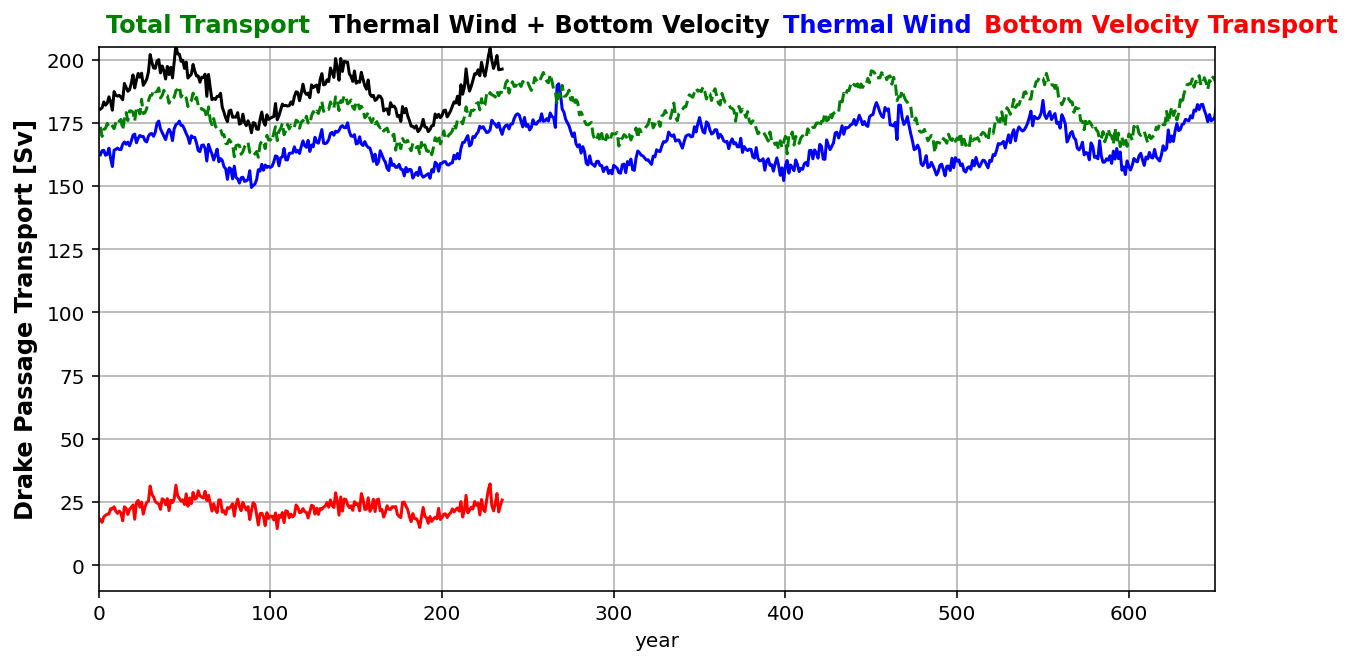

In [94]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_esm4_cmip6.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_esm4_cmip6.groupby('time.year').mean().squeeze().plot(color='red')
total_esm4_cmip6.groupby('time.year').mean().squeeze().plot(color='k')
total_umo_esm4_cmip6.groupby('time.year').mean().squeeze().plot(color='green',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

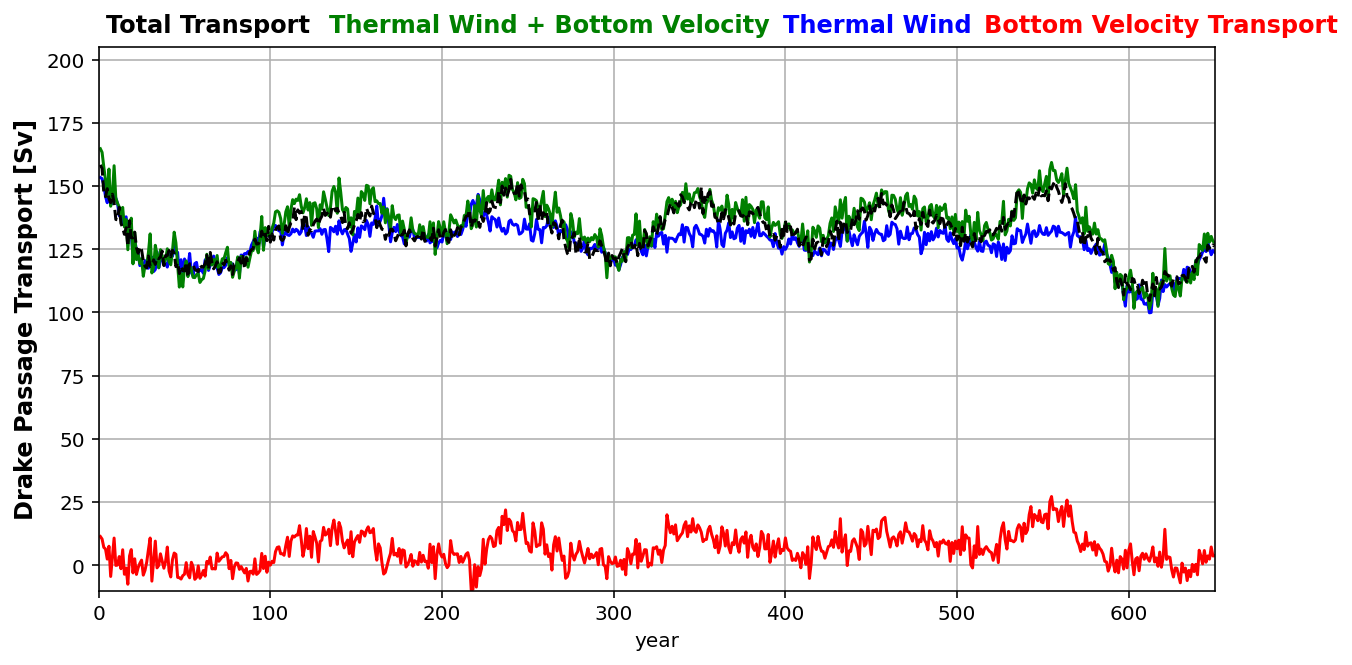

In [95]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_cm4_cmip6.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_cm4_cmip6.groupby('time.year').mean().squeeze().plot(color='red')
total_cm4_cmip6.groupby('time.year').mean().squeeze().plot(color='green')
total_umo_cm4_cmip6.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='k',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='green',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

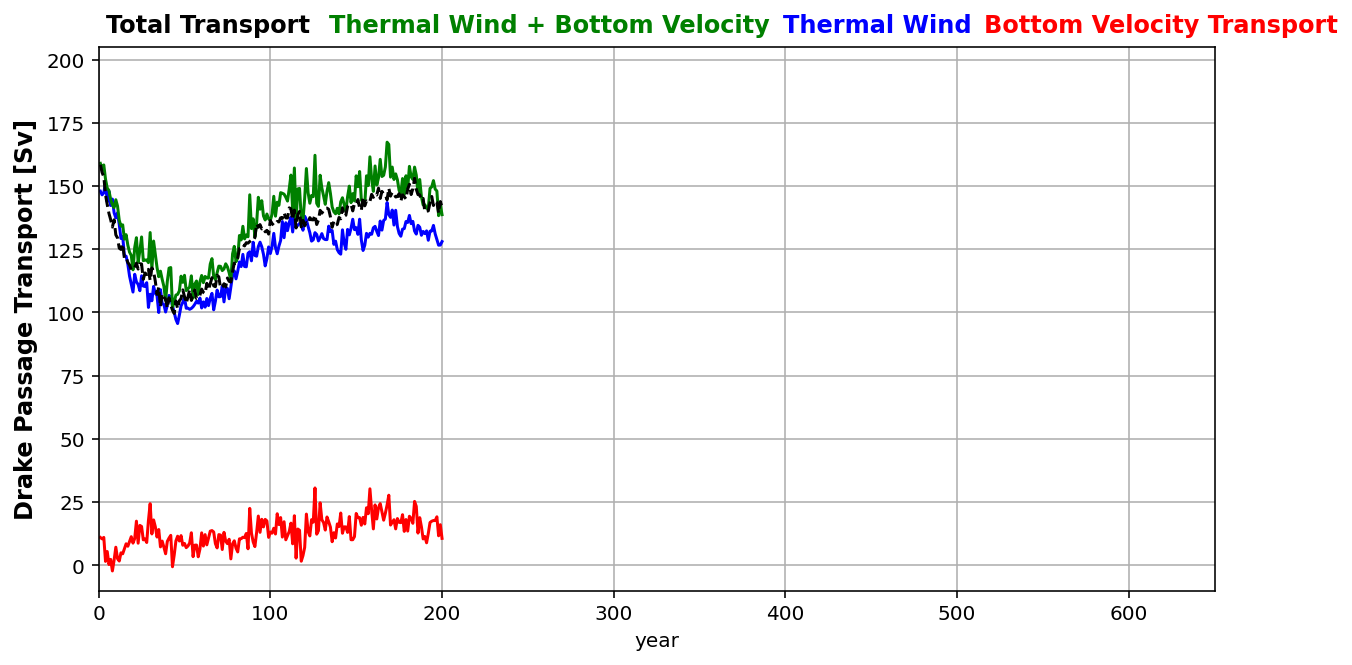

In [96]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_170.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_170.groupby('time.year').mean().squeeze().plot(color='red')
total_170.groupby('time.year').mean().squeeze().plot(color='green')
total_umo_170.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='k',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='green',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

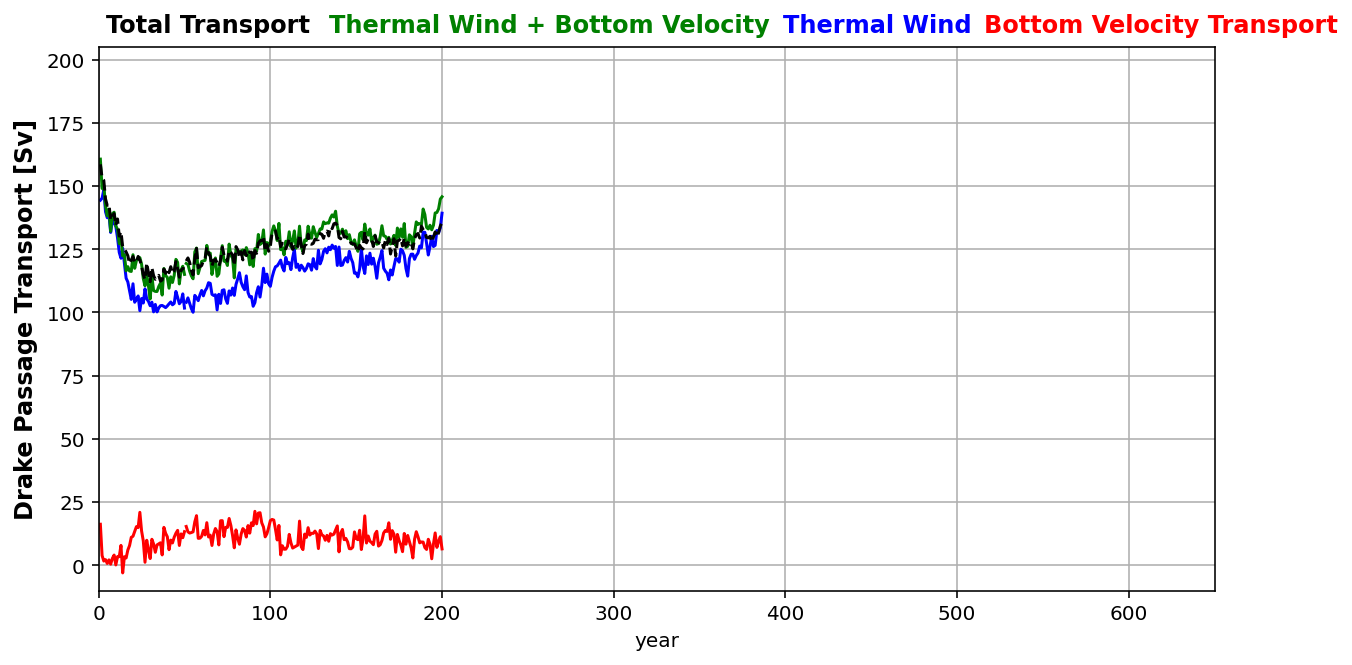

In [97]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_183.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
BC_T_184.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_183.groupby('time.year').mean().squeeze().plot(color='red')
Sv_Bottom_184.groupby('time.year').mean().squeeze().plot(color='red')
total_183.groupby('time.year').mean().squeeze().plot(color='green')
total_184.groupby('time.year').mean().squeeze().plot(color='green')
total_umo_183.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')
total_umo_184.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='k',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='green',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

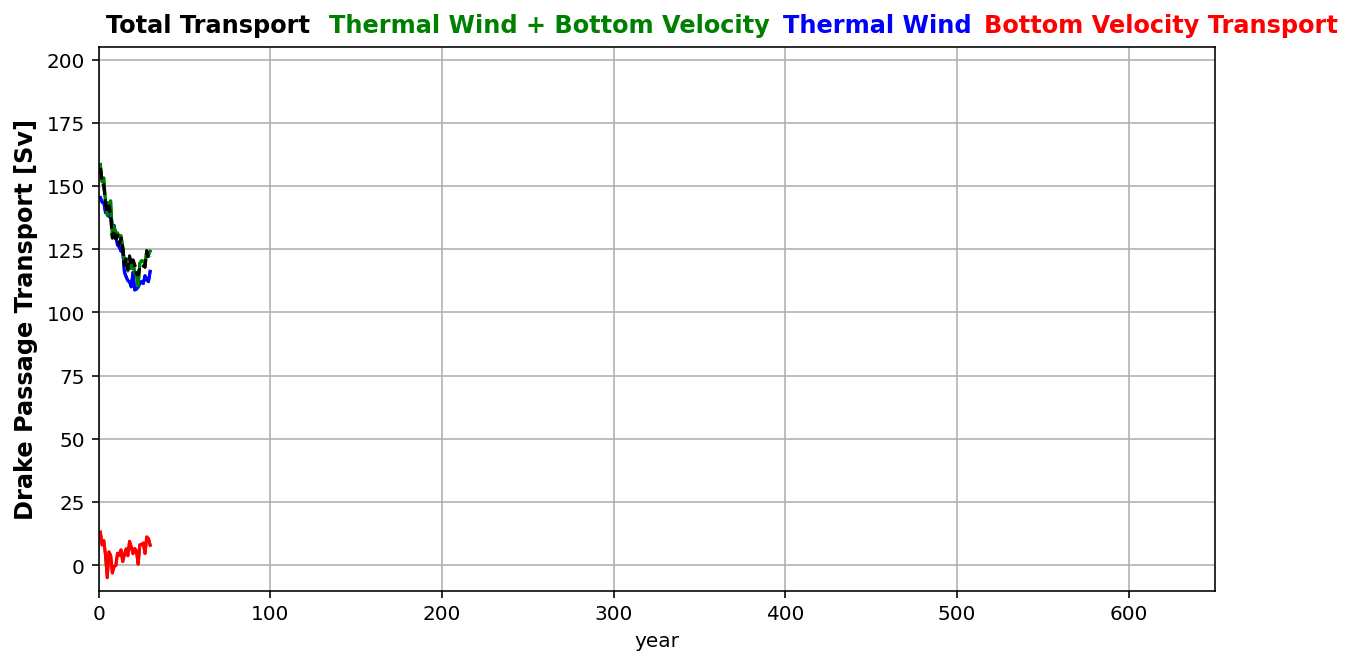

In [98]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_191.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
BC_T_191.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_191.groupby('time.year').mean().squeeze().plot(color='red')
Sv_Bottom_191.groupby('time.year').mean().squeeze().plot(color='red')
total_191.groupby('time.year').mean().squeeze().plot(color='green')
total_191.groupby('time.year').mean().squeeze().plot(color='green')
total_umo_191.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')
total_umo_191.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='k',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='green',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

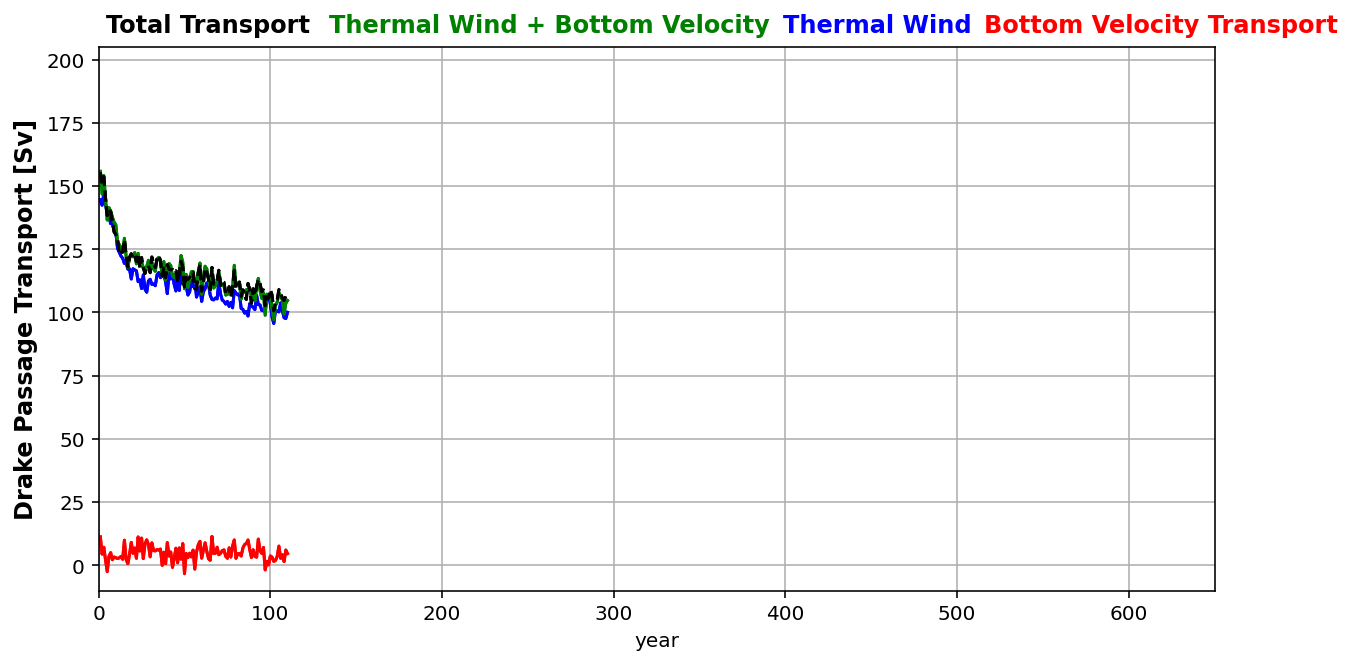

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

BC_T_200.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
BC_T_200.groupby('time.year').mean(dim='time').squeeze().plot(color='blue',linewidth=1.5)
Sv_Bottom_200.groupby('time.year').mean().squeeze().plot(color='red')
Sv_Bottom_200.groupby('time.year').mean().squeeze().plot(color='red')
total_200.groupby('time.year').mean().squeeze().plot(color='green')
total_200.groupby('time.year').mean().squeeze().plot(color='green')
total_umo_200.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')
total_umo_200.groupby('time.year').mean().squeeze().plot(color='black',linestyle='--')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)
plt.xlim(0,650)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='k',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='green',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

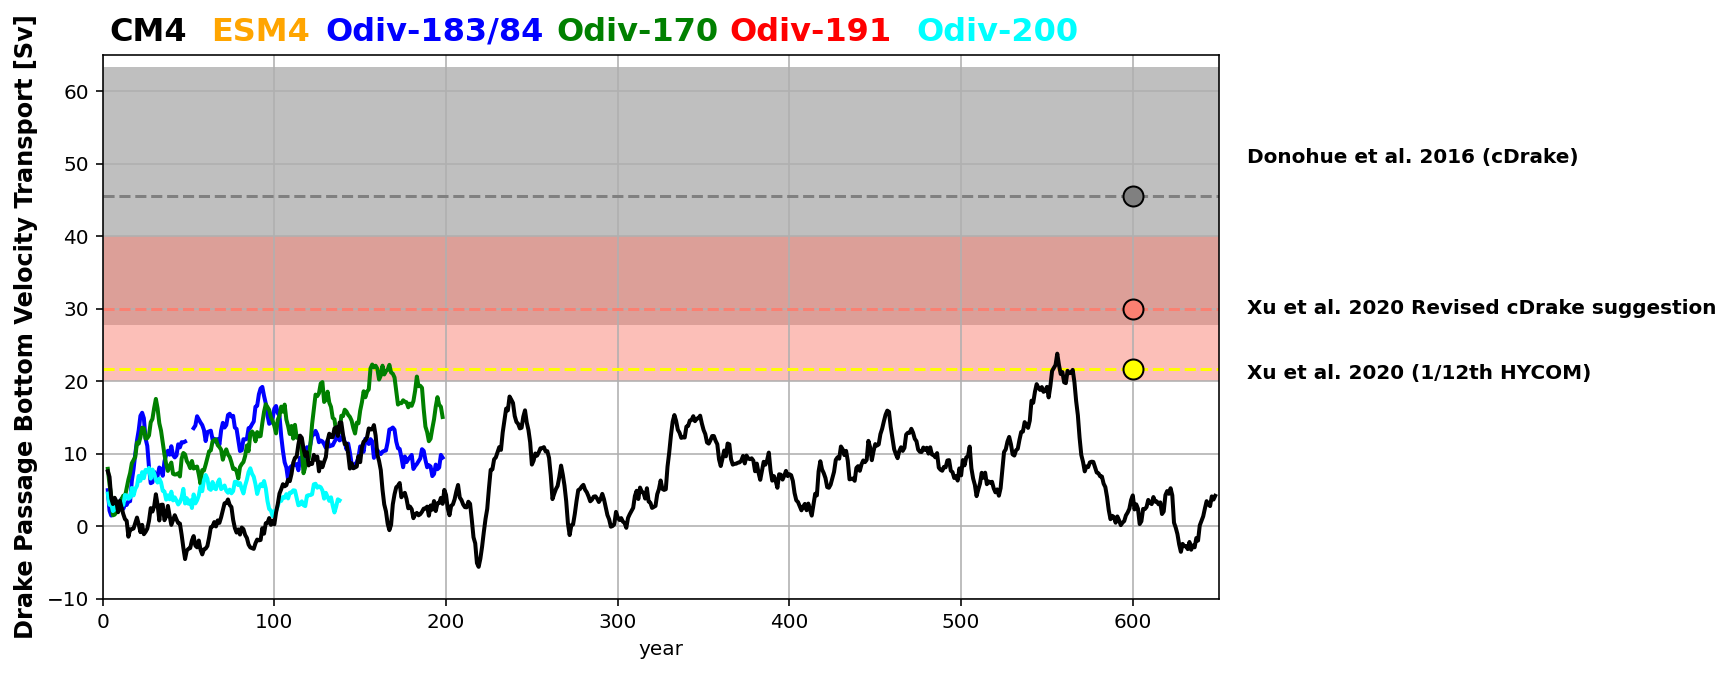

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

x_end = 600

x_all = (0,650)

y_cDrake = (27.8)
y1_cDrake = (63.4)
y2_cDrake = (45.6)  ## Value of 127.7 +/- 8.1 Sv (standard dev) from Chidichimo et al. 2014

Xu_revised_cDrake = (30)
Xu_revised_cDrake_upper = (40) 
Xu_revised_cDrake_lower = (20)

Xu_2020 = (21.7)

ax.fill_between(x_all,y_cDrake,y1_cDrake,facecolor='grey',alpha=0.5)
ax.fill_between(x_all,Xu_revised_cDrake_lower,Xu_revised_cDrake_upper,facecolor='salmon',alpha=0.5)

plt.axhline(y=45.6,linestyle='--',color='grey')
plt.axhline(y=21.7,linestyle='--',color='yellow')
plt.axhline(y=30,linestyle='--',color='salmon')

Sv_Bottom_183.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
Sv_Bottom_184.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='blue',linewidth=2)
Sv_Bottom_170.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='green',linewidth=2)
#Sv_Bottom_191.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='red',linewidth=2)
Sv_Bottom_200.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='cyan',linewidth=2)
Sv_Bottom_cm4_cmip6.groupby('time.year').mean().squeeze().chunk(chunks={'year':2}).rolling(year=5,center=True).mean().plot(color='black',linewidth=2)
#Sv_Bottom_esm4_cmip6.groupby('time.year').mean().squeeze().chunk(chunks={'year':4}).rolling(year=5,center=True).mean().plot(color='orange',linewidth=2)

ax.set_ylabel('Drake Passage Bottom Velocity Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,65)
plt.xlim(0,650)

plt.plot(x_end,y2_cDrake,marker='o',markersize=10,markerfacecolor='grey',markeredgecolor='k')
plt.plot(x_end,Xu_revised_cDrake,marker='o',markersize=10,markerfacecolor='salmon',markeredgecolor='k')
plt.plot(x_end,Xu_2020,marker='o',markersize=10,markerfacecolor='yellow',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.20,0.90,'ESM4',fontsize=16,color='orange',fontweight='bold')
fig.text(0.28,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.44,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.56,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.69,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')

fig.text(0.92,0.73,'Donohue et al. 2016 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.43,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.52,'Xu et al. 2020 Revised cDrake suggestion',fontsize=10,color='black',fontweight='bold')

plt.title('')

### Create cross-sections plots of Thermal Wind velocity

In [21]:
## Cannot have NaNs to use as coordinate in pcolormesh:
def forward_fill(arr):
    """ Forward fill a 2-D array along the column dimension"""
    # make a copy of the input array
    out = arr * 1.0
    # loop over column index
    for col_idx in range(0,arr.shape[1]):
        # get the column to work on
        _row = arr[:,col_idx]
        # get index numbers of nan values
        _nan_vals = np.argwhere(np.isnan(_row))
        # find the last "good" value
        _depth = 0. if _nan_vals[0] == 0 else _row[_nan_vals[0]-1]
        # set nan values to the last good value
        _row = np.where(np.isnan(_row),_depth,_row)
        # re-assign the filled column
        out[:,col_idx] = _row
    return out

In [22]:
#### Get models true bathymetry for Odiv170
#### This is partial cell thickness in Drake on T points:
thk_Odiv170 = cm4_170_vol.volcello.isel(time=0) / cm4_static_170.areacello.sel(yh=slice(-70.40,-54.49))
thk_Odiv170_Drake = thk_Odiv170.sel(yh=slice(-70,-55)).sel(xh=-70,method='nearest').load()
Odiv170_lat_Drake = cm4_static_170.yh.sel(yh=slice(-70,-55))

#### Get depth to the center of the partial cell in Drake:
kmax = thk_Odiv170_Drake.shape[0]                                           ## Maximum k value, == 35
zl_Drake_Odiv170  = 0.0 * thk_Odiv170_Drake[:]                              ## Take all the values for thickness at Drake and multiply by zero. 
zl_Drake_Odiv170[0] = 0.5 * thk_Odiv170_Drake[0]                            ## Multiple first element by 0.5.

k_Drake = 1
while k_Drake < kmax:
    zl_Drake_Odiv170[k_Drake] = zl_Drake_Odiv170[k_Drake-1] + 0.5 * (thk_Odiv170_Drake[k_Drake]+thk_Odiv170_Drake[k_Drake-1])
    k_Drake=k_Drake+1
    
zl_Drake_Odiv170_nm = np.array(zl_Drake_Odiv170)

zl_Drake_Odiv170 = forward_fill(zl_Drake_Odiv170_nm)
Odiv_170_lat_Drake_b = np.broadcast_to(Odiv170_lat_Drake,zl_Drake_Odiv170.shape)

In [23]:
#### Note there is an issue here with the coordinates and the Drake Passage is located at -65, not -69 ...
#### Get models true bathymetry for Odiv184
#### This is partial cell thickness in Drake on T points:
thk_Odiv184 = cm4_184_vol.volcello.isel(time=0) / cm4_static_184.areacello.sel(yh=slice(-70,-55))
thk_Odiv184_Drake = thk_Odiv184.sel(yh=slice(-70,-55)).sel(xh=-65,method='nearest').load()
Odiv184_lat_Drake = cm4_static_184.yh.sel(yh=slice(-70,-55))

#### Get depth to the center of the partial cell in Drake:
kmax = thk_Odiv184_Drake.shape[0]                                           ## Maximum k value, == 35
zl_Drake_Odiv184  = 0.0 * thk_Odiv184_Drake[:]                              ## Take all the values for thickness at Drake and multiply by zero. 
zl_Drake_Odiv184[0] = 0.5 * thk_Odiv184_Drake[0]                            ## Multiple first element by 0.5.

k_Drake = 1
while k_Drake < kmax:
    zl_Drake_Odiv184[k_Drake] = zl_Drake_Odiv184[k_Drake-1] + 0.5 * (thk_Odiv184_Drake[k_Drake]+thk_Odiv184_Drake[k_Drake-1])
    k_Drake=k_Drake+1
    
zl_Drake_Odiv184_nm = np.array(zl_Drake_Odiv184.squeeze())

zl_Drake_Odiv184 = forward_fill(zl_Drake_Odiv184_nm)
Odiv_184_lat_Drake_b = np.broadcast_to(Odiv184_lat_Drake,zl_Drake_Odiv184.shape)

In [24]:
#### Note there is an issue here with the coordinates and the Drake Passage is located at -65, not -69 ...
#### Get models true bathymetry for Odiv184
#### This is partial cell thickness in Drake on T points:
thk_Odiv200 = cm4_200_vol.volcello.isel(time=0) / cm4_static_200.areacello.sel(yh=slice(-70,-55))
thk_Odiv200_Drake = thk_Odiv200.sel(yh=slice(-70,-55)).sel(xh=-65,method='nearest').load()
Odiv200_lat_Drake = cm4_static_200.yh.sel(yh=slice(-70,-55))

#### Get depth to the center of the partial cell in Drake:
kmax = thk_Odiv200_Drake.shape[0]                                           ## Maximum k value, == 35
zl_Drake_Odiv200  = 0.0 * thk_Odiv200_Drake[:]                              ## Take all the values for thickness at Drake and multiply by zero. 
zl_Drake_Odiv200[0] = 0.5 * thk_Odiv200_Drake[0]                            ## Multiple first element by 0.5.

k_Drake = 1
while k_Drake < kmax:
    zl_Drake_Odiv200[k_Drake] = zl_Drake_Odiv200[k_Drake-1] + 0.5 * (thk_Odiv200_Drake[k_Drake]+thk_Odiv200_Drake[k_Drake-1])
    k_Drake=k_Drake+1
    
zl_Drake_Odiv200_nm = np.array(zl_Drake_Odiv200.squeeze())

zl_Drake_Odiv200 = forward_fill(zl_Drake_Odiv200_nm)
Odiv_200_lat_Drake_b = np.broadcast_to(Odiv200_lat_Drake,zl_Drake_Odiv200.shape)

In [25]:
#### Get models true bathymetry for CM4 CMIP6
#### This is partial cell thickness in Drake on T points:
thk_cmip6 = cm4_cmip6_vol.volcello.isel(time=0) / cm4_cmip6_static.areacello.sel(yh=slice(-70.40,-54.49))
thk_cmip6_Drake = thk_cmip6.sel(yh=slice(-70,-55)).sel(xh=-70,method='nearest').load()
cmip6_lat_Drake = cm4_cmip6_static.yh.sel(yh=slice(-70,-55))

#### Get depth to the center of the partial cell in Drake:
kmax = thk_cmip6_Drake.shape[0]                                           ## Maximum k value, == 35
zl_Drake_cmip6  = 0.0 * thk_cmip6_Drake[:]                              ## Take all the values for thickness at Drake and multiply by zero. 
zl_Drake_cmip6[0] = 0.5 * thk_cmip6_Drake[0]                            ## Multiple first element by 0.5.

k_Drake = 1
while k_Drake < kmax:
    zl_Drake_cmip6[k_Drake] = zl_Drake_cmip6[k_Drake-1] + 0.5 * (thk_cmip6_Drake[k_Drake]+thk_cmip6_Drake[k_Drake-1])
    k_Drake=k_Drake+1
    
zl_Drake_cmip6_nm = np.array(zl_Drake_cmip6.squeeze())

zl_Drake_cmip6 = forward_fill(zl_Drake_cmip6_nm)
cmip6_lat_Drake_b = np.broadcast_to(cmip6_lat_Drake,zl_Drake_cmip6.shape)

NameError: name 'cm4_cmip6_vol' is not defined

In [28]:
#### Get models true bathymetry for ESM4 CMIP6
#### This is partial cell thickness in Drake on T points:
thk_esm4_cmip6 = esm4_cmip6_vol.volcello.isel(time=0) / esm4_cmip6_static.areacello.sel(yh=slice(-70,-55.21))
thk_esm4_cmip6_Drake = thk_esm4_cmip6.sel(yh=slice(-70,-55.21)).sel(xh=-70,method='nearest').load()
esm4_cmip6_lat_Drake = esm4_cmip6_static.yh.sel(yh=slice(-70,-55.21))

#### Get depth to the center of the partial cell in Drake:
kmax = thk_esm4_cmip6_Drake.shape[0]                                           ## Maximum k value, == 35
zl_Drake_esm4_cmip6  = 0.0 * thk_esm4_cmip6_Drake[:]                              ## Take all the values for thickness at Drake and multiply by zero. 
zl_Drake_esm4_cmip6[0] = 0.5 * thk_esm4_cmip6_Drake[0]                            ## Multiple first element by 0.5.

k_Drake = 1
while k_Drake < kmax:
    zl_Drake_esm4_cmip6[k_Drake] = zl_Drake_esm4_cmip6[k_Drake-1] + 0.5 * (thk_esm4_cmip6_Drake[k_Drake]+thk_esm4_cmip6_Drake[k_Drake-1])
    k_Drake=k_Drake+1
    
zl_Drake_esm4_cmip6_nm = np.array(zl_Drake_esm4_cmip6.squeeze())

zl_Drake_esm4_cmip6 = forward_fill(zl_Drake_esm4_cmip6_nm)
esm4_cmip6_lat_Drake_b = np.broadcast_to(esm4_cmip6_lat_Drake,zl_Drake_esm4_cmip6.shape)

NameError: name 'esm4_cmip6_vol' is not defined

/vftmp/Rebecca.Beadling/pid28087/ipykernel_31849/1679941029.py:44: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar=plt.colorbar(cbr,cax=cax,orientation='vertical',shrink=0.5,ticks = [-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20],extend='both')


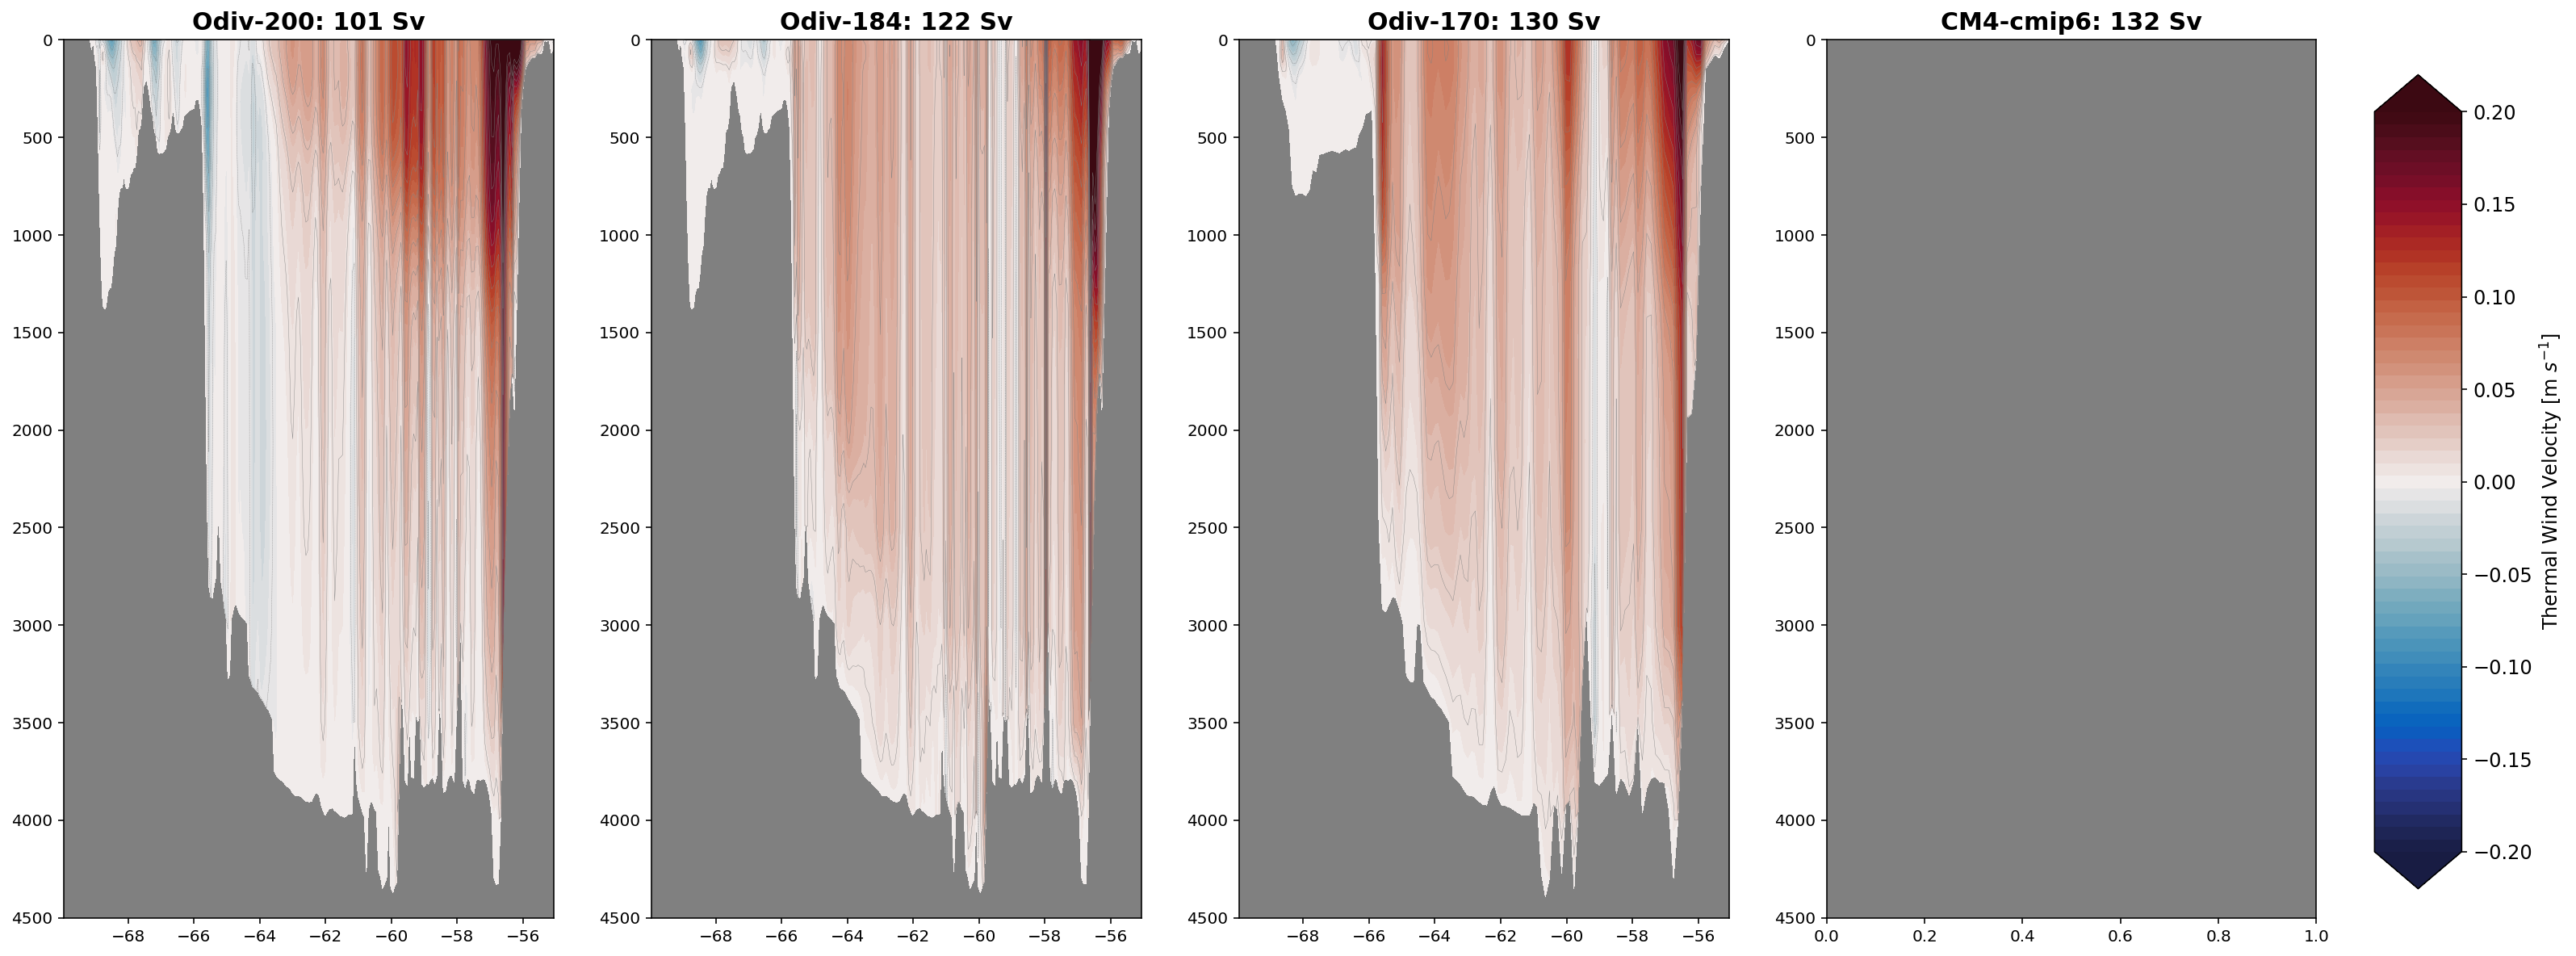

In [26]:
from matplotlib import gridspec
from matplotlib import colorbar

fig, ax = plt.subplots(1,4,figsize=(25,10))
gs = gridspec.GridSpec(1,4)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0],facecolor='grey'),plt.subplot(gs[0,1],facecolor='grey'),plt.subplot(gs[0,2],facecolor='grey'),plt.subplot(gs[0,3],facecolor='grey')

custom_ylim = (4500,0)
plt.setp(ax1, ylim=custom_ylim)
plt.setp(ax2, ylim=custom_ylim)
plt.setp(ax3, ylim=custom_ylim)
plt.setp(ax4, ylim=custom_ylim)

levels_vel = np.linspace(-0.2,0.2,60)
levels_vel_contour = np.linspace(-0.2,0.2,30)

### reindex z_l for plotting:
ugeo_170_reindex = ugeo_170.reindex(z_l=ugeo_170.z_l[::-1]).sel(time=slice('0161-01-16','0180-12-16')).mean(dim='time')
ugeo_184_reindex = ugeo_184.reindex(z_l=ugeo_184.z_l[::-1]).sel(time=slice('0161-01-16','0180-12-16')).mean(dim='time').isel(yq=slice(1,262))
#ugeo_cm4_reindex = ugeo_cm4.reindex(z_l=ugeo_cm4.z_l[::-1]).sel(time=slice('0121-01-16','0140-12-16')).mean(dim='time')
ugeo_200_reindex = ugeo_200.reindex(z_l=ugeo_200.z_l[::-1]).sel(time=slice('0161-01-16','0180-12-16')).mean(dim='time').isel(yq=slice(1,262))
#ugeo_esm4_reindex = ugeo_esm4.reindex(z_l=ugeo_esm4.z_l[::-1]).sel(time=slice('0181-01-16','0200-12-16')).mean(dim='time')

ax3.contourf(Odiv_170_lat_Drake_b,zl_Drake_Odiv170,ugeo_170_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
ax2.contourf(Odiv_184_lat_Drake_b,zl_Drake_Odiv184,ugeo_184_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
#ax4.contourf(cmip6_lat_Drake_b,zl_Drake_cmip6,ugeo_cm4_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
ax1.contourf(Odiv_200_lat_Drake_b,zl_Drake_Odiv200,ugeo_200_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
#ax4.contourf(esm4_cmip6_lat_Drake_b,zl_Drake_esm4_cmip6,ugeo_esm4_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)

ax3.contour(Odiv_170_lat_Drake_b,zl_Drake_Odiv170,ugeo_170_reindex.values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
ax2.contour(Odiv_184_lat_Drake_b,zl_Drake_Odiv184,ugeo_184_reindex.values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
#ax4.contour(cmip6_lat_Drake_b,zl_Drake_cmip6,ugeo_cm4_reindex.values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
ax1.contour(Odiv_200_lat_Drake_b,zl_Drake_Odiv200,ugeo_200_reindex.values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
#ax4.contour(esm4_cmip6_lat_Drake_b,zl_Drake_esm4_cmip6,ugeo_esm4_reindex.values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)

ax2.set_title("Odiv-184: 122 Sv",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-170: 130 Sv",fontsize=15, fontweight='bold')
ax4.set_title("CM4-cmip6: 132 Sv",fontsize=15, fontweight='bold')
ax1.set_title("Odiv-200: 101 Sv",fontsize=15, fontweight='bold')

## Add colorbar:
cax = fig.add_axes([0.92, 0.15, 0.030, 0.70])
cbr = ax2.contourf(Odiv_184_lat_Drake_b,zl_Drake_Odiv184,ugeo_184_reindex.values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
cbar=plt.colorbar(cbr,cax=cax,orientation='vertical',shrink=0.5,ticks = [-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20],extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Thermal Wind Velocity [m $s^{-1}$]', fontsize=12)

### Create cross-sections plots of Thermal Wind velocity

/vftmp/Rebecca.Beadling/pid28087/ipykernel_31849/2625649324.py:42: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar=plt.colorbar(cbr,cax=cax,orientation='vertical',shrink=0.5,ticks = [-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20],extend='both')


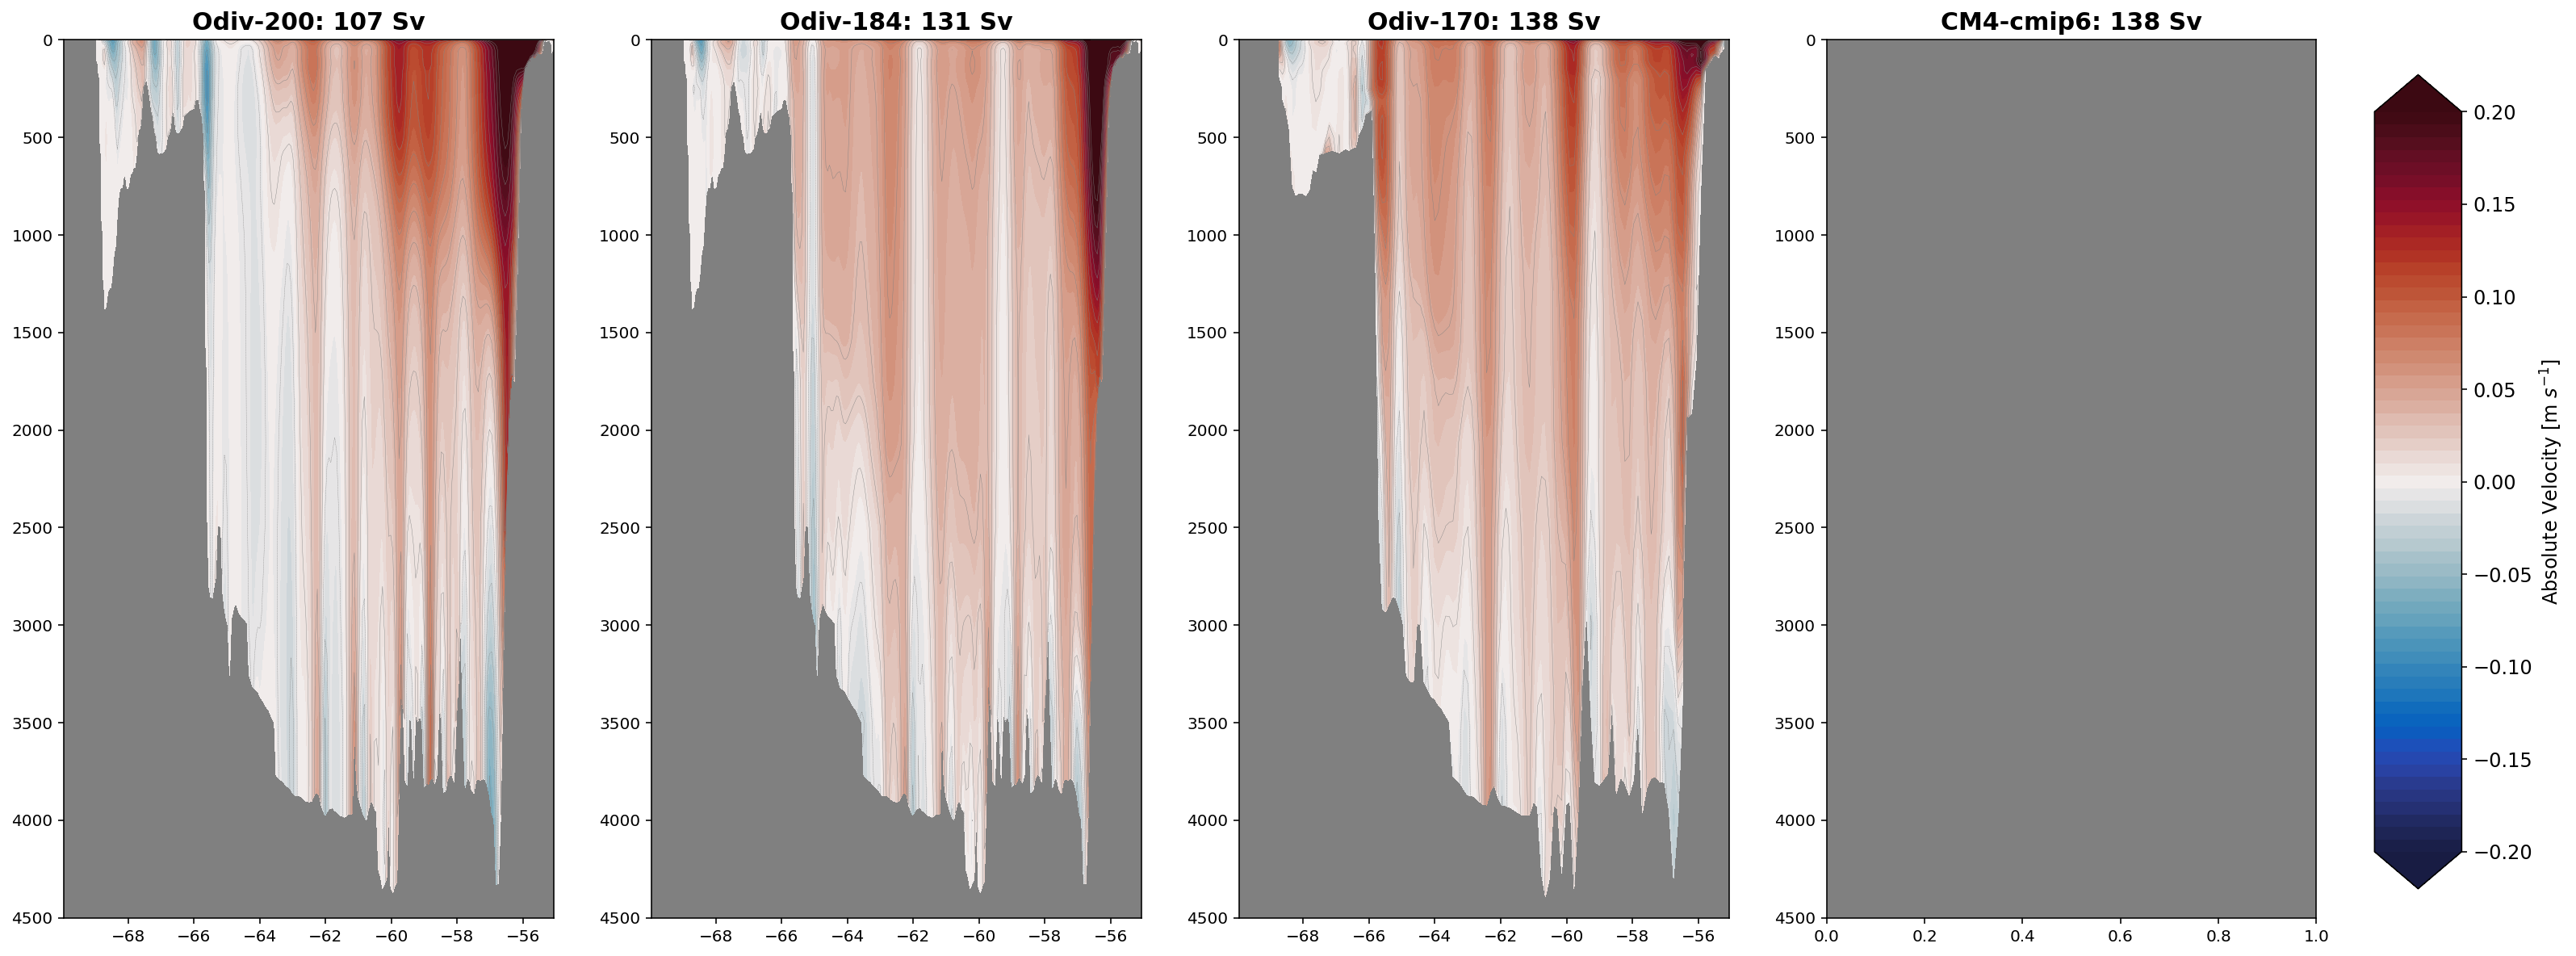

In [30]:
### Cross-sections of Absolute Velocity 
from matplotlib import gridspec
from matplotlib import colorbar

fig, ax = plt.subplots(1,4,figsize=(25,10))
gs = gridspec.GridSpec(1,4)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0],facecolor='grey'),plt.subplot(gs[0,1],facecolor='grey'),plt.subplot(gs[0,2],facecolor='grey'),plt.subplot(gs[0,3],facecolor='grey')

custom_ylim = (4500,0)
plt.setp(ax1, ylim=custom_ylim)
plt.setp(ax2, ylim=custom_ylim)
plt.setp(ax3, ylim=custom_ylim)
plt.setp(ax4, ylim=custom_ylim)

levels_vel = np.linspace(-0.2,0.2,60)
levels_vel_contour = np.linspace(-0.2,0.2,30)



ax3.contourf(Odiv_170_lat_Drake_b,zl_Drake_Odiv170,cm4_170_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(4,134)).values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
ax2.contourf(Odiv_184_lat_Drake_b,zl_Drake_Odiv184,cm4_184_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(14,275)).values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
#ax4.contourf(cmip6_lat_Drake_b,zl_Drake_cmip6,cm4_cmip6_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(0,130)).values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
ax1.contourf(Odiv_200_lat_Drake_b,zl_Drake_Odiv200,cm4_200_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(14,275)).values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
#ax4.contourf(esm4_cmip6_lat_Drake_b,zl_Drake_esm4_cmip6,esm4_cmip6_uo.uo.sel(time=slice('0181-01-16','0200-12-16')).isel(yh=slice(3,69)).mean(dim='time').values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)

ax3.contour(Odiv_170_lat_Drake_b,zl_Drake_Odiv170,cm4_170_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(4,134)).values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
ax2.contour(Odiv_184_lat_Drake_b,zl_Drake_Odiv184,cm4_184_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(14,275)).values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
#ax4.contour(cmip6_lat_Drake_b,zl_Drake_cmip6,cm4_cmip6_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(0,130)).values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
ax1.contour(Odiv_200_lat_Drake_b,zl_Drake_Odiv200,cm4_200_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(14,275)).values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)
#ax4.contour(esm4_cmip6_lat_Drake_b,zl_Drake_esm4_cmip6,esm4_cmip6_uo.uo.sel(time=slice('0181-01-16','0200-12-16')).isel(yh=slice(3,69)).mean(dim='time').values,levels=levels_vel_contour,colors='grey',vmin=-0.2,vmax=0.2,linewidths=0.20)


ax2.set_title("Odiv-184: 131 Sv",fontsize=15, fontweight='bold')
ax3.set_title("Odiv-170: 138 Sv",fontsize=15, fontweight='bold')
ax4.set_title("CM4-cmip6: 138 Sv",fontsize=15, fontweight='bold')
#ax4.set_title("ESM4-cmip6: 165.82 Sv",fontsize=15, fontweight='bold')
ax1.set_title("Odiv-200: 107 Sv",fontsize=15, fontweight='bold')

## Add colorbar:
cax = fig.add_axes([0.92, 0.15, 0.030, 0.70])
ax1.contourf(Odiv_200_lat_Drake_b,zl_Drake_Odiv200,cm4_200_uo.uo.sel(time=slice('0141-01-16','0160-12-16')).mean(dim='time').isel(yh=slice(14,275)).values,levels=levels_vel,cmap=cmocean.cm.balance,extend='both',vmin=-0.2,vmax=0.2)
cbar=plt.colorbar(cbr,cax=cax,orientation='vertical',shrink=0.5,ticks = [-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20],extend='both')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Absolute Velocity [m $s^{-1}$]', fontsize=12)

In [34]:
BC_T_cm4_cmip6.sel(time=slice('0121-01-16','0140-12-16')).mean(dim='time').values,\
#BC_T_esm4_cmip6.sel(time=slice('0081-01-16','0100-12-16')).mean(dim='time').values,\
#BC_T_170.sel(time=slice('0121-01-16','0140-12-16')).mean(dim='time').values,\
#BC_T_184.sel(time=slice('0121-01-16','0140-12-16')).mean(dim='time').values,\
#BC_T_200.sel(time=slice('0121-01-16','0140-12-16')).mean(dim='time').values

(array(131.84308769),)

In [47]:
Sv_Bottom_170.sel(time=slice('0081-01-16','0200-12-16')).mean(dim='time').values,\
Sv_Bottom_184.sel(time=slice('0081-01-16','0200-12-16')).mean(dim='time').values,\
Sv_Bottom_200.sel(time=slice('0081-01-16','0200-12-16')).mean(dim='time').values,\
Sv_Bottom_cm4_cmip6.sel(time=slice('0081-01-16','0200-12-16')).mean(dim='time').values,\
#Sv_Bottom_esm4_cmip6.sel(time=slice('0081-01-16','0200-12-16')).mean(dim='time').values

(array(15.69054393), array(11.13257494), array(4.57614963), array(5.77755471))